In [1]:
MODEL_VERSION = "00"
NUM_TIMESTEPS = 28
RUN_ON_SAMPLE = True
SCALING = True
PLOTTING = True

BS = 256
NUM_EPOCHS = 50
LR = 5e-4
DROPOUT = 0.3
TRAILING_VAL_RATIO = 0.1

In [2]:
import pandas as pd
import numpy as np
import os, sys, datetime, pickle
from time import time, ctime
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, TimeDistributed
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import RepeatVector, Lambda
from tensorflow.keras.backend import repeat_elements

In [3]:
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [5]:
seeded_value = 88888
pd.set_option('display.max_colwidth', 50)
np.random.seed(seeded_value)
tf.random.set_seed(seeded_value)

In [6]:
# suppress scientific notation
np.set_printoptions(suppress=True)

In [7]:
print([
    tf.__version__
])

['2.1.0']


In [8]:
start_time = ctime(time())
print(start_time)

Sun Jun  7 02:43:00 2020


### Files
1. calendar.csv - Contains information about the dates on which the products are sold.
2. sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
3. sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.
4. sell_prices.csv - Contains information about the price of the products sold per store and date.
5. sales_train_evaluation.csv - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)

In [9]:
DATA_DIR = "../data/"
RESULTS_DIR = "../results/"

In [10]:
## All data imports
#calendar = pd.read_csv(DATA_DIR+"calendar.csv")
sales_train_validation = pd.read_csv(DATA_DIR+"sales_train_validation.csv")
#sample_submission = pd.read_csv(DATA_DIR+"sample_submission.csv")
#sell_prices = pd.read_csv(DATA_DIR+"sell_prices.csv")
#sales_train_evaluation = pd.read_csv(DATA_DIR+"sales_train_evaluation.csv")

Reduce size for quicker experimentation

In [11]:
if RUN_ON_SAMPLE:
    old_shape = sales_train_validation.shape
    sales_train_validation = sales_train_validation.sample(frac=0.05).reset_index(drop=True)
    print(old_shape, "--->", sales_train_validation.shape)

(30490, 1919) ---> (1524, 1919)


Get the number of uniques in each cardinal variable

In [12]:
FEATURES = [i for i in sales_train_validation.columns if i.startswith("d_")]
data = sales_train_validation[FEATURES].values.transpose()
NUM_DAYS, NUM_SERIES = data.shape[0], data.shape[1]
print({
    "NUM_DAYS" : NUM_DAYS,
    "NUM_SERIES" : NUM_SERIES
})

{'NUM_DAYS': 1913, 'NUM_SERIES': 1524}


In [13]:
Category_Mapping = {}

CARDINALS = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
CARDINALITY = {i:sales_train_validation[i].nunique() for i in CARDINALS}
print(CARDINALITY)

for c in CARDINALS:
    # convert columns to categories
    sales_train_validation[c] = sales_train_validation[c].astype("category")
    
    # save the mapping for later use
    Category_Mapping.update({c:dict(enumerate(sales_train_validation[c].cat.categories))})
    
    # Copy categories as integer codes
    sales_train_validation[c+"_cat"] = sales_train_validation[c].cat.codes

categoricals = sales_train_validation[[c+"_cat" for c in CARDINALS]].values
print(categoricals.shape)

{'item_id': 1226, 'dept_id': 7, 'cat_id': 3, 'store_id': 10, 'state_id': 3}
(1524, 5)


In [14]:
def scale_array(x, min_threshold, max_threshold):
     return (x - np.min(x)) * (max_threshold - min_threshold) / (np.max(x) - np.min(x)) + min_threshold;

In [15]:
if SCALING:
    
    data_scaled = 0.9 * data / np.max(data)
    
    #MMS = MinMaxScaler((0.1, 0.90))
    #MMS.fit(data)
    #data_scaled = MMS.fit_transform(data)
    
    #data_scaled = scale_array(x = data,
    #                          min_threshold = 0.1,
    #                          max_threshold = 0.9)
    
    tsgX = TimeseriesGenerator(
        data=data_scaled,
        targets=data_scaled,
        length=NUM_TIMESTEPS,
        sampling_rate=1,
        stride=1,
        end_index=NUM_DAYS - NUM_TIMESTEPS - 1,
        batch_size=BS
    )

    tsgY = TimeseriesGenerator(
        data=data_scaled,
        targets=data_scaled,
        length=NUM_TIMESTEPS,
        sampling_rate=1,
        stride=1,
        start_index=NUM_TIMESTEPS,
        batch_size=BS
    )
else:
    tsgX = TimeseriesGenerator(
        data=data,
        targets=data,
        length=NUM_TIMESTEPS,
        sampling_rate=1,
        stride=1,
        end_index=NUM_DAYS - NUM_TIMESTEPS - 1,
        batch_size=BS
    )

    tsgY = TimeseriesGenerator(
        data=data,
        targets=data,
        length=NUM_TIMESTEPS,
        sampling_rate=1,
        stride=1,
        start_index=NUM_TIMESTEPS,
        batch_size=BS
    )

In [16]:
X, Y = np.empty((BS, NUM_TIMESTEPS, NUM_SERIES)), np.empty((BS, NUM_TIMESTEPS, NUM_SERIES))
print((BS, NUM_TIMESTEPS, NUM_SERIES))

(256, 28, 1524)


In [17]:
for i in range(len(tsgX)):
    x1, _ = tsgX[i]
    y1, _ = tsgY[i]
    
    X, Y = np.concatenate((X, x1)), np.concatenate((Y, y1))

In [18]:
X.shape, Y.shape, len(tsgX)

((2113, 28, 1524), (2113, 28, 1524), 8)

In [19]:
EMB_SIZES = {k:round(max(2, min(v/2, 10))) for k,v in CARDINALITY.items()}

In [20]:
cat_input = Input(shape = (NUM_TIMESTEPS,), name='cat_input')
dept_input = Input(shape = (NUM_TIMESTEPS,), name='dept_input')
item_input = Input(shape = (NUM_TIMESTEPS,), name='item_input')
state_input = Input(shape = (NUM_TIMESTEPS,), name='state_input')
store_input = Input(shape = (NUM_TIMESTEPS,), name='store_input')

series_input = Input(shape=(NUM_TIMESTEPS, 1), name="time_series_input")

emb_cat = Embedding(CARDINALITY["cat_id"], EMB_SIZES["cat_id"], name='emb_cat')(cat_input)
emb_dept = Embedding(CARDINALITY["dept_id"], EMB_SIZES["dept_id"], name='emb_dept')(dept_input)
emb_item = Embedding(CARDINALITY["item_id"], EMB_SIZES["item_id"], name='emb_item')(item_input)
emb_state = Embedding(CARDINALITY["state_id"], EMB_SIZES["state_id"], name='emb_state')(state_input)
emb_store = Embedding(CARDINALITY["store_id"], EMB_SIZES["store_id"], name='emb_store')(store_input)

emb_inputs = concatenate([
    emb_cat,
    emb_dept,
    emb_item,
    emb_state,
    emb_store
])

all_inputs = concatenate([emb_inputs, series_input])

x2 = LSTM(units=128, return_sequences=True)(all_inputs)
x2 = BatchNormalization()(x2)
x2 = Activation("relu")(x2)
x2 = Dropout(DROPOUT)(x2)

x2 = LSTM(units=128, return_sequences=True)(x2)
x2 = BatchNormalization()(x2)
x2 = Activation("relu")(x2)
x2 = Dropout(DROPOUT)(x2)

x2 = LSTM(units=128, return_sequences=True)(x2)
x2 = BatchNormalization()(x2)
x2 = Activation("relu")(x2)
x2 = Dropout(DROPOUT)(x2)

output = LSTM(units=1, return_sequences=True, activation="sigmoid", name="time_series_output")(x2)

In [21]:
model = Model([series_input, cat_input, dept_input, item_input, state_input, store_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cat_input (InputLayer)          [(None, 28)]         0                                            
__________________________________________________________________________________________________
dept_input (InputLayer)         [(None, 28)]         0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 28)]         0                                            
__________________________________________________________________________________________________
state_input (InputLayer)        [(None, 28)]         0                                            
______________________________________________________________________________________________

In [22]:
adam = Adam(learning_rate=LR)
model.compile(loss='mse', optimizer=adam)

In [23]:
mcp = ModelCheckpoint(filepath=RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5", monitor='val_loss',
                      verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

csvl = CSVLogger(filename=RESULTS_DIR+MODEL_VERSION+"_LossLogs.csv",
                 separator=",", append=True)

In [24]:
def repeater(x):
    x = np.repeat(x, repeats=NUM_TIMESTEPS).reshape(-1,1)
    return np.repeat(x, repeats=len(X)).reshape(-1, NUM_TIMESTEPS)

In [25]:
metric_names = ['loss']

Fit for series: ['HOUSEHOLD_2_460' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['FOODS_3_770' 'FOODS_3' 'FOODS' 'TX_1' 'TX']


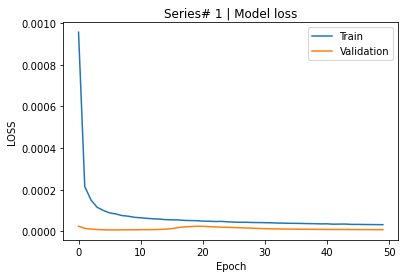

Fit for series: ['HOBBIES_2_043' 'HOBBIES_2' 'HOBBIES' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_2_370' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['FOODS_1_137' 'FOODS_1' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOBBIES_1_242' 'HOBBIES_1' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['FOODS_3_205' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOBBIES_2_122' 'HOBBIES_2' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['FOODS_1_047' 'FOODS_1' 'FOODS' 'CA_3' 'CA']


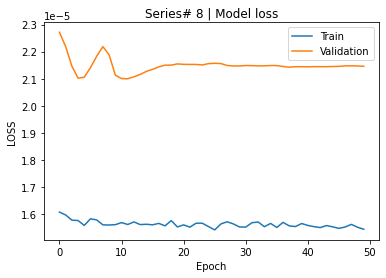

Fit for series: ['FOODS_3_264' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_2_200' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']


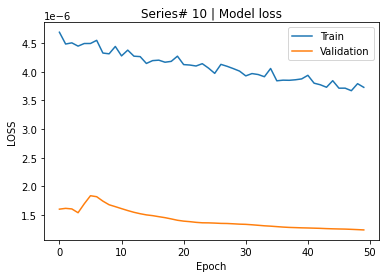

Fit for series: ['HOBBIES_1_031' 'HOBBIES_1' 'HOBBIES' 'CA_4' 'CA']


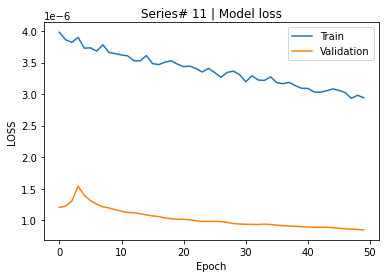

Fit for series: ['FOODS_3_123' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOBBIES_1_283' 'HOBBIES_1' 'HOBBIES' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_004' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_051' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_1_345' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_090' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['FOODS_2_034' 'FOODS_2' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_1_358' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['FOODS_1_084' 'FOODS_1' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_3_339' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_146' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['FOODS_3_356' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_2_161' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_2_107' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_

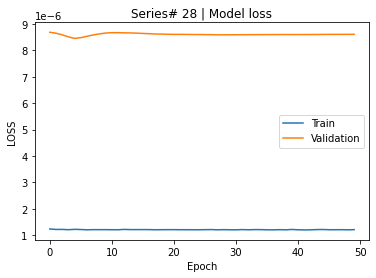

Fit for series: ['HOBBIES_1_076' 'HOBBIES_1' 'HOBBIES' 'WI_2' 'WI']
Fit for series: ['FOODS_2_373' 'FOODS_2' 'FOODS' 'WI_2' 'WI']
Fit for series: ['FOODS_2_244' 'FOODS_2' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_3_528' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOBBIES_2_083' 'HOBBIES_2' 'HOBBIES' 'WI_1' 'WI']


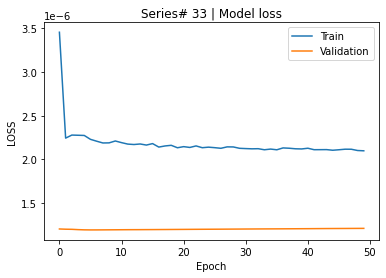

Fit for series: ['FOODS_3_569' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_410' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_2_059' 'FOODS_2' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_2_277' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_2_009' 'FOODS_2' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOBBIES_2_033' 'HOBBIES_2' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_2_439' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_1' 'WI']


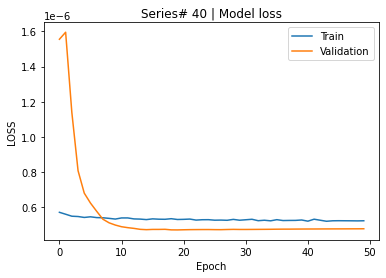

Fit for series: ['FOODS_3_505' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_1_246' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOBBIES_1_098' 'HOBBIES_1' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['FOODS_2_283' 'FOODS_2' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_2_516' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['FOODS_3_608' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['FOODS_3_738' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_2_426' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOBBIES_1_163' 'HOBBIES_1' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['FOODS_3_293' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_1_172' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['FOODS_3_812' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['FOODS_3_521' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_2_104' 'FOODS_2' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_2_340' 'FOODS_2' 'FOODS' 'CA_2' 'CA']
Fit for se

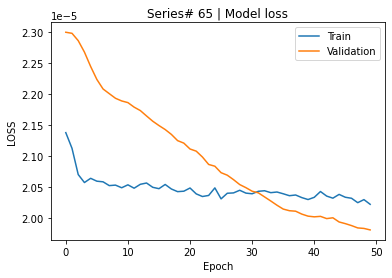

Fit for series: ['HOUSEHOLD_2_258' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_171' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']


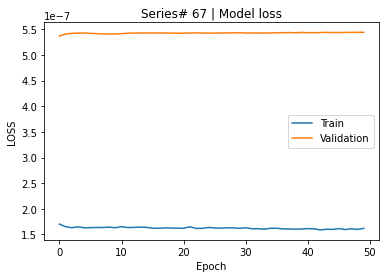

Fit for series: ['HOUSEHOLD_1_380' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['FOODS_3_343' 'FOODS_3' 'FOODS' 'CA_2' 'CA']


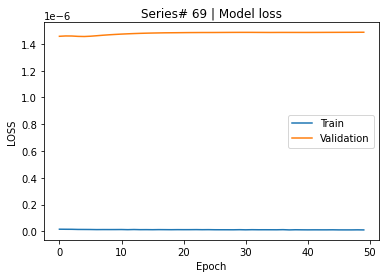

Fit for series: ['HOUSEHOLD_1_442' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['FOODS_3_047' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_3_087' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['FOODS_2_382' 'FOODS_2' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_3_687' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_381' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['FOODS_3_012' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOBBIES_2_140' 'HOBBIES_2' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_027' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_1_261' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['FOODS_3_165' 'FOODS_3' 'FOODS' 'TX_1' 'TX']


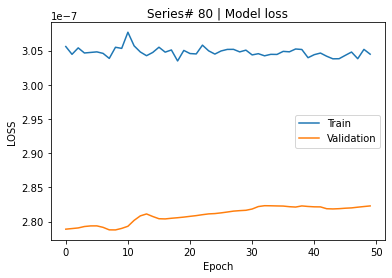

Fit for series: ['HOUSEHOLD_2_228' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['FOODS_3_223' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOBBIES_1_366' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_2_450' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['HOBBIES_1_423' 'HOBBIES_1' 'HOBBIES' 'WI_1' 'WI']
Fit for series: ['HOBBIES_1_400' 'HOBBIES_1' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['HOBBIES_1_098' 'HOBBIES_1' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['FOODS_3_655' 'FOODS_3' 'FOODS' 'TX_3' 'TX']


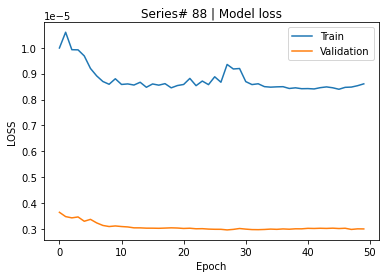

Fit for series: ['FOODS_1_018' 'FOODS_1' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_3_291' 'FOODS_3' 'FOODS' 'CA_1' 'CA']


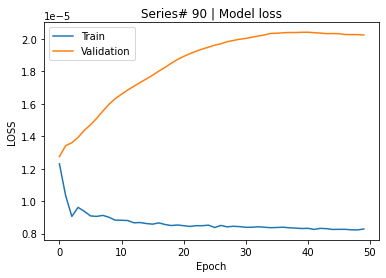

Fit for series: ['FOODS_2_149' 'FOODS_2' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_1_439' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_2' 'CA']


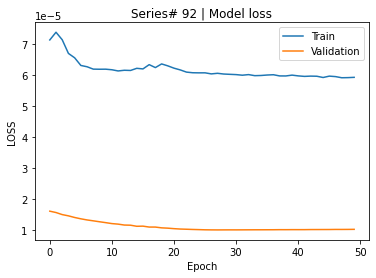

Fit for series: ['FOODS_3_606' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_3_563' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_383' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOBBIES_1_298' 'HOBBIES_1' 'HOBBIES' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_1_468' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_2_115' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['FOODS_1_027' 'FOODS_1' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_2_292' 'FOODS_2' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_2_141' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['FOODS_3_827' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOBBIES_1_387' 'HOBBIES_1' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_1_466' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']


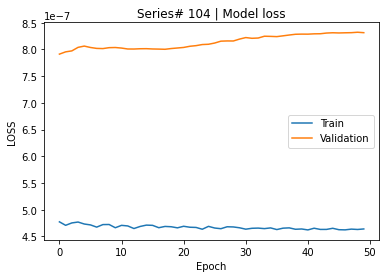

Fit for series: ['HOBBIES_1_263' 'HOBBIES_1' 'HOBBIES' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_2_062' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['FOODS_3_602' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_3_543' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_3_069' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_1_196' 'FOODS_1' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_1_519' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['FOODS_3_246' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOBBIES_1_361' 'HOBBIES_1' 'HOBBIES' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_2_208' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']


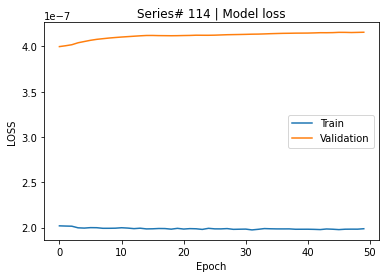

Fit for series: ['HOUSEHOLD_2_257' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_1_443' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_056' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['FOODS_2_368' 'FOODS_2' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_2_375' 'FOODS_2' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOBBIES_2_137' 'HOBBIES_2' 'HOBBIES' 'WI_1' 'WI']
Fit for series: ['HOBBIES_1_106' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['FOODS_2_340' 'FOODS_2' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_3_647' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_1_163' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOBBIES_1_246' 'HOBBIES_1' 'HOBBIES' 'TX_3' 'TX']


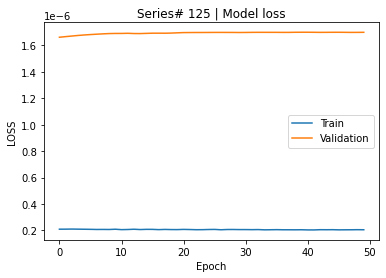

Fit for series: ['FOODS_3_643' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOBBIES_1_349' 'HOBBIES_1' 'HOBBIES' 'CA_1' 'CA']
Fit for series: ['FOODS_3_490' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_2_079' 'FOODS_2' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_2_274' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['FOODS_2_113' 'FOODS_2' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_2_206' 'FOODS_2' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOBBIES_1_399' 'HOBBIES_1' 'HOBBIES' 'WI_1' 'WI']


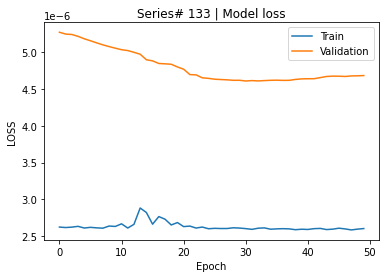

Fit for series: ['HOUSEHOLD_1_521' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['FOODS_3_027' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_3_262' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_1_493' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']


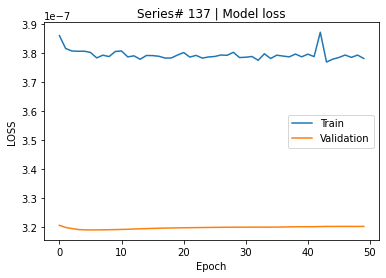

Fit for series: ['HOUSEHOLD_2_334' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOBBIES_2_095' 'HOBBIES_2' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_2_291' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_1_333' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOBBIES_2_109' 'HOBBIES_2' 'HOBBIES' 'WI_2' 'WI']
Fit for series: ['FOODS_2_237' 'FOODS_2' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_2_212' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['FOODS_2_090' 'FOODS_2' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_2_430' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_1_470' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_3_343' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['FOODS_2_227' 'FOODS_2' 'FOODS' 'CA_4' 'CA']
Fit for series: ['FOODS_3_452' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOBBIES_2_015' 'HOBBIES_2' 'HOBBIES' 'CA_1' 'CA']
Fit for series: ['FOODS_1_139' 'FOODS_1' '

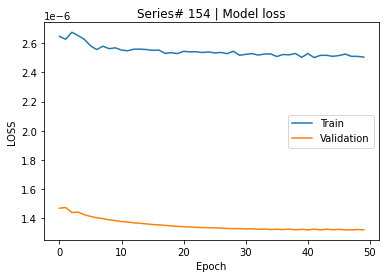

Fit for series: ['HOUSEHOLD_1_265' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_2' 'WI']


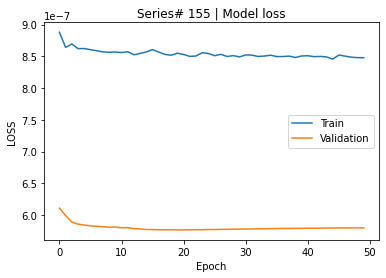

Fit for series: ['FOODS_2_343' 'FOODS_2' 'FOODS' 'CA_1' 'CA']


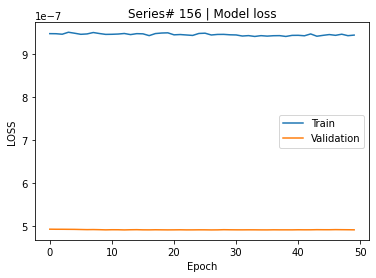

Fit for series: ['FOODS_3_123' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_3_633' 'FOODS_3' 'FOODS' 'TX_3' 'TX']


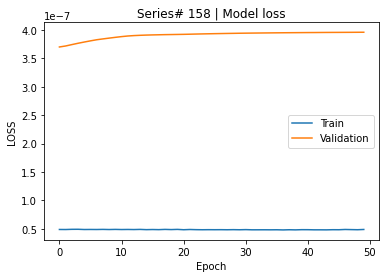

Fit for series: ['FOODS_3_149' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_428' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOBBIES_1_149' 'HOBBIES_1' 'HOBBIES' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_2_178' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_2_091' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOBBIES_2_122' 'HOBBIES_2' 'HOBBIES' 'CA_1' 'CA']
Fit for series: ['FOODS_1_175' 'FOODS_1' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOBBIES_1_325' 'HOBBIES_1' 'HOBBIES' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_1_010' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOBBIES_2_006' 'HOBBIES_2' 'HOBBIES' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_1_086' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOBBIES_2_128' 'HOBBIES_2' 'HOBBIES' 'TX_1' 'TX']
Fit for series: ['HOBBIES_2_107' 'HOBBIES_2' 'HOBBIES' 'CA_1' 'CA']
Fit for series: ['FOODS_3_761' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['FOODS_1_080' 'FOOD

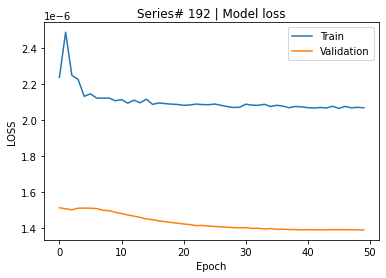

Fit for series: ['HOUSEHOLD_1_455' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['FOODS_3_331' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_3_438' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['FOODS_3_707' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_3_169' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_2_159' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_104' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_184' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_376' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']


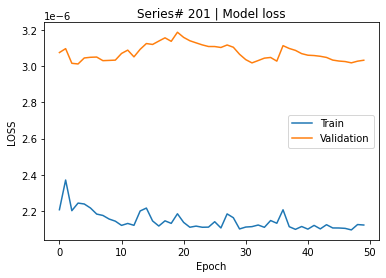

Fit for series: ['FOODS_3_367' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['FOODS_3_536' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_1_151' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_2_096' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_2_334' 'FOODS_2' 'FOODS' 'WI_2' 'WI']
Fit for series: ['FOODS_3_338' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['FOODS_1_146' 'FOODS_1' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_2_455' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['FOODS_2_116' 'FOODS_2' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOBBIES_1_237' 'HOBBIES_1' 'HOBBIES' 'TX_3' 'TX']
Fit for series: ['FOODS_3_744' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['FOODS_1_139' 'FOODS_1' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_478' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['FOODS_2_361' 'FOODS_2' 'FOODS' 'TX_3' 'TX']
Fit for series: ['FOODS_3_543' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: 

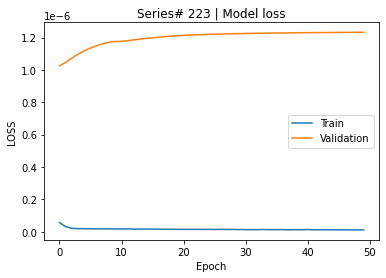

Fit for series: ['FOODS_3_537' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_1_503' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['FOODS_3_200' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOBBIES_1_323' 'HOBBIES_1' 'HOBBIES' 'WI_1' 'WI']
Fit for series: ['FOODS_3_348' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOBBIES_1_180' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_1_150' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['FOODS_1_048' 'FOODS_1' 'FOODS' 'CA_4' 'CA']
Fit for series: ['FOODS_1_117' 'FOODS_1' 'FOODS' 'CA_4' 'CA']
Fit for series: ['FOODS_3_199' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['FOODS_3_688' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_1_442' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOBBIES_1_205' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']
Fit for series: ['FOODS_2_246' 'FOODS_2' 'FOODS' 'TX_2' 'TX']


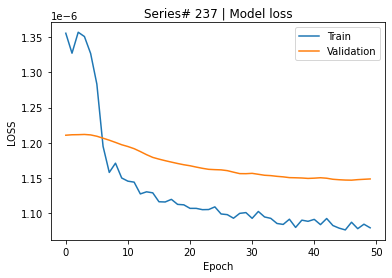

Fit for series: ['FOODS_3_424' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['FOODS_3_479' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_3_262' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_478' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_400' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']


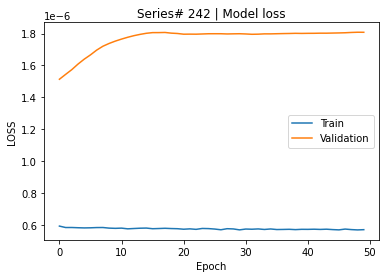

Fit for series: ['FOODS_3_056' 'FOODS_3' 'FOODS' 'CA_2' 'CA']


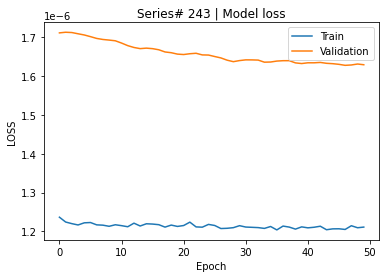

Fit for series: ['FOODS_3_675' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['FOODS_2_346' 'FOODS_2' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_3_261' 'FOODS_3' 'FOODS' 'CA_3' 'CA']


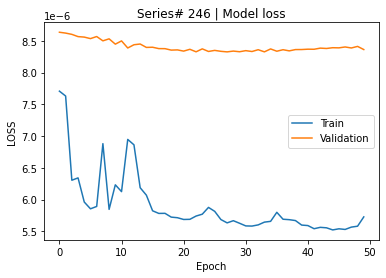

Fit for series: ['FOODS_2_092' 'FOODS_2' 'FOODS' 'CA_1' 'CA']


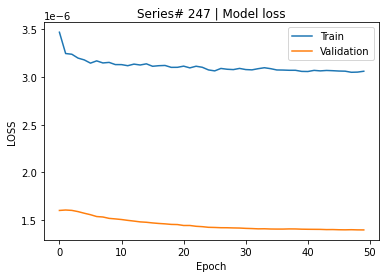

Fit for series: ['HOUSEHOLD_1_018' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['FOODS_3_662' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_2_163' 'FOODS_2' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_3_192' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_2_398' 'FOODS_2' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOBBIES_1_103' 'HOBBIES_1' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['HOBBIES_1_097' 'HOBBIES_1' 'HOBBIES' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_1_492' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['FOODS_3_705' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_172' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_1_458' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['FOODS_3_798' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_477' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['FOODS_2_269' 'FOODS_2' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_485' 'HOUSEHOLD_1' 'HOUSEHOLD'

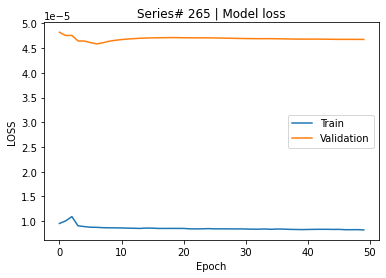

Fit for series: ['FOODS_3_102' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOBBIES_1_230' 'HOBBIES_1' 'HOBBIES' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_1_434' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_2_435' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['FOODS_3_459' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_3_784' 'FOODS_3' 'FOODS' 'WI_1' 'WI']


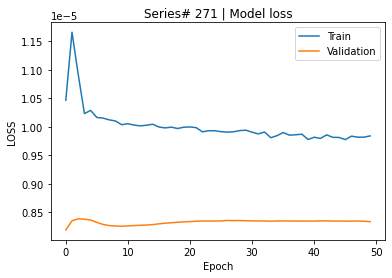

Fit for series: ['FOODS_3_456' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_328' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['FOODS_3_217' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOBBIES_1_050' 'HOBBIES_1' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['FOODS_3_670' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOBBIES_2_086' 'HOBBIES_2' 'HOBBIES' 'CA_1' 'CA']


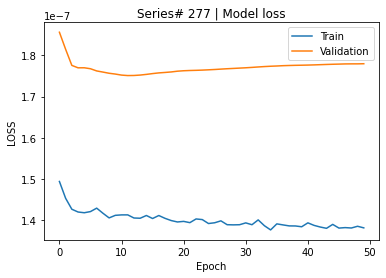

Fit for series: ['HOUSEHOLD_2_193' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_2_039' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOBBIES_1_302' 'HOBBIES_1' 'HOBBIES' 'TX_1' 'TX']
Fit for series: ['FOODS_2_087' 'FOODS_2' 'FOODS' 'CA_4' 'CA']
Fit for series: ['FOODS_3_377' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_3_046' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_1_135' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_024' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['FOODS_3_556' 'FOODS_3' 'FOODS' 'TX_1' 'TX']


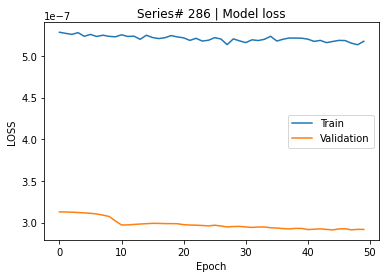

Fit for series: ['FOODS_3_111' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['FOODS_2_024' 'FOODS_2' 'FOODS' 'WI_2' 'WI']


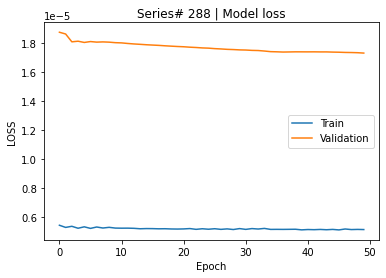

Fit for series: ['FOODS_3_498' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_1_287' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_1_323' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_289' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']


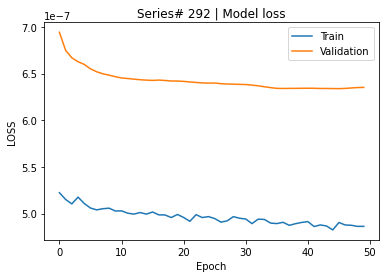

Fit for series: ['FOODS_2_052' 'FOODS_2' 'FOODS' 'CA_3' 'CA']
Fit for series: ['FOODS_3_532' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['FOODS_3_097' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_141' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['FOODS_2_076' 'FOODS_2' 'FOODS' 'WI_2' 'WI']


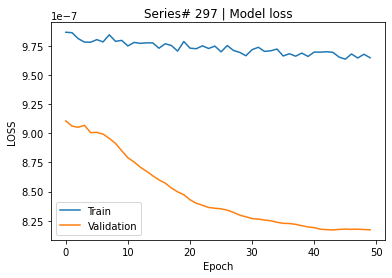

Fit for series: ['HOUSEHOLD_2_118' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_1_423' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['FOODS_3_596' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_2_133' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_2_410' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOBBIES_1_407' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']
Fit for series: ['HOBBIES_2_033' 'HOBBIES_2' 'HOBBIES' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_2_095' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOBBIES_1_418' 'HOBBIES_1' 'HOBBIES' 'TX_3' 'TX']
Fit for series: ['FOODS_3_575' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOBBIES_2_080' 'HOBBIES_2' 'HOBBIES' 'CA_4' 'CA']
Fit for series: ['FOODS_3_259' 'FOODS_3' 'FOODS' 'WI_1' 'WI']


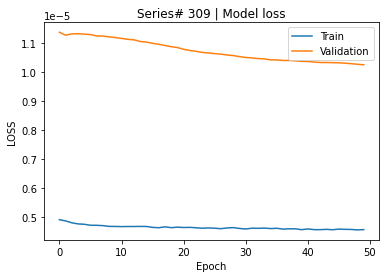

Fit for series: ['FOODS_3_371' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOBBIES_2_021' 'HOBBIES_2' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_190' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_097' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_133' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['FOODS_2_110' 'FOODS_2' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_1_064' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_1_137' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOBBIES_2_019' 'HOBBIES_2' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_2_013' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_038' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_1_191' 'FOODS_1' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOBBIES_1_370' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['HOBBIES_1_203' 'HOBBIES_1' 'HOBBIES' 'WI_2' 'WI']
Fit for series: ['HOUSEH

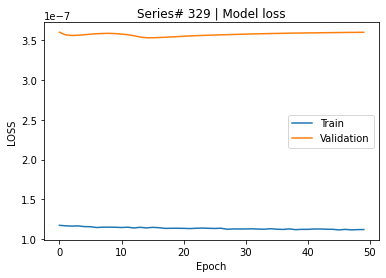

Fit for series: ['HOUSEHOLD_1_120' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_1_520' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOBBIES_2_141' 'HOBBIES_2' 'HOBBIES' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_2_467' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_1_381' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['FOODS_3_197' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_3_219' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['FOODS_3_289' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_2_030' 'FOODS_2' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOBBIES_1_176' 'HOBBIES_1' 'HOBBIES' 'CA_1' 'CA']
Fit for series: ['HOBBIES_1_403' 'HOBBIES_1' 'HOBBIES' 'CA_4' 'CA']


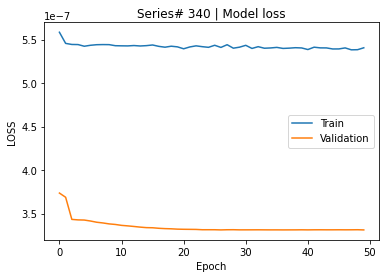

Fit for series: ['HOUSEHOLD_1_319' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_3_463' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_231' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_1_173' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['FOODS_3_283' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['FOODS_2_104' 'FOODS_2' 'FOODS' 'WI_2' 'WI']
Fit for series: ['FOODS_2_231' 'FOODS_2' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_113' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_513' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOBBIES_1_048' 'HOBBIES_1' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_340' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['FOODS_3_040' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['FOODS_2_066' 'FOODS_2' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_2_274' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['FOODS_2_003' 'FOODS_2' '

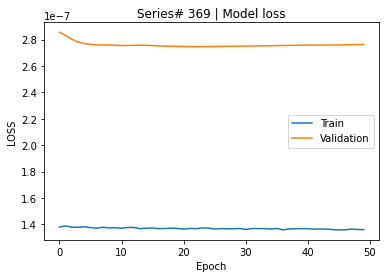

Fit for series: ['HOUSEHOLD_2_006' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_3_424' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_1_099' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_3_693' 'FOODS_3' 'FOODS' 'CA_3' 'CA']


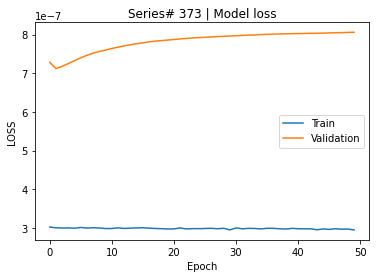

Fit for series: ['FOODS_3_630' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_3_767' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['FOODS_2_202' 'FOODS_2' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_386' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['FOODS_3_285' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOBBIES_1_348' 'HOBBIES_1' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_1_103' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['FOODS_3_220' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_1_501' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']


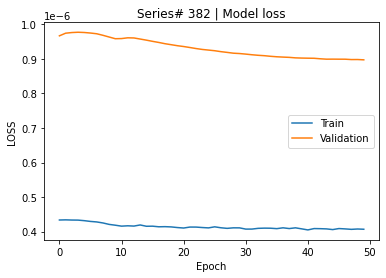

Fit for series: ['HOBBIES_1_097' 'HOBBIES_1' 'HOBBIES' 'TX_3' 'TX']


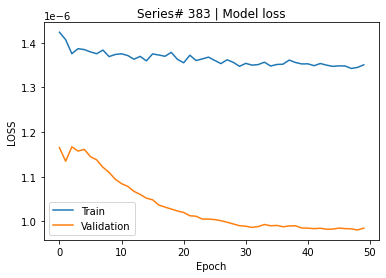

Fit for series: ['HOUSEHOLD_1_281' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['FOODS_2_187' 'FOODS_2' 'FOODS' 'CA_4' 'CA']
Fit for series: ['FOODS_1_010' 'FOODS_1' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_335' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_2_037' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_2_111' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_2_331' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['FOODS_2_027' 'FOODS_2' 'FOODS' 'TX_3' 'TX']
Fit for series: ['FOODS_3_192' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOBBIES_1_201' 'HOBBIES_1' 'HOBBIES' 'WI_1' 'WI']


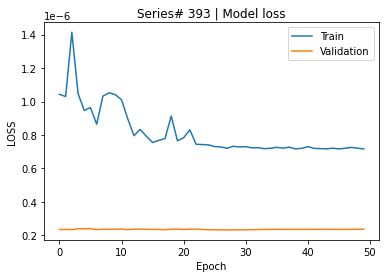

Fit for series: ['HOBBIES_1_005' 'HOBBIES_1' 'HOBBIES' 'CA_4' 'CA']


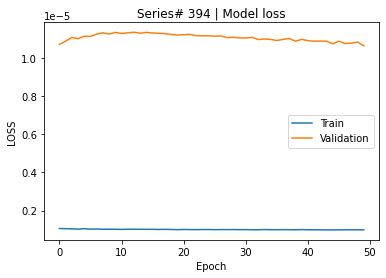

Fit for series: ['FOODS_3_147' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_245' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_1_174' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_121' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_2' 'WI']


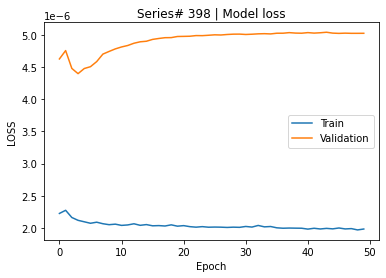

Fit for series: ['HOUSEHOLD_1_199' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_025' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOBBIES_2_104' 'HOBBIES_2' 'HOBBIES' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_2_124' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_1_133' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_3_442' 'FOODS_3' 'FOODS' 'CA_1' 'CA']


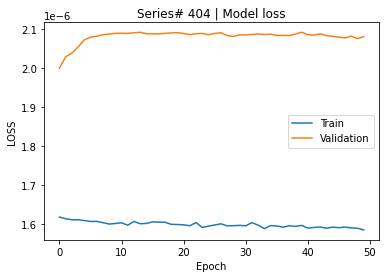

Fit for series: ['HOUSEHOLD_1_310' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_1_246' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOBBIES_1_116' 'HOBBIES_1' 'HOBBIES' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_1_004' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_195' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOBBIES_1_247' 'HOBBIES_1' 'HOBBIES' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_365' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_191' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_2_367' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['HOBBIES_1_248' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']


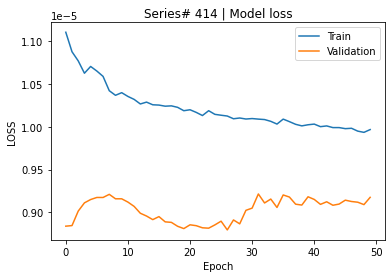

Fit for series: ['FOODS_3_742' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['FOODS_3_019' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOBBIES_1_352' 'HOBBIES_1' 'HOBBIES' 'CA_4' 'CA']
Fit for series: ['FOODS_2_148' 'FOODS_2' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_1_071' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']


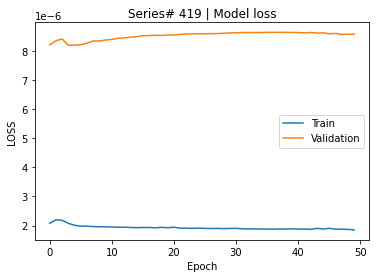

Fit for series: ['FOODS_3_725' 'FOODS_3' 'FOODS' 'WI_3' 'WI']


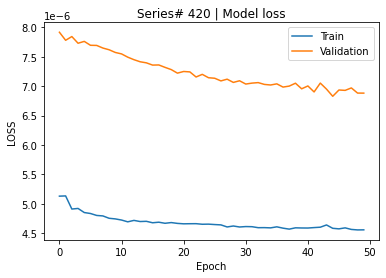

Fit for series: ['HOUSEHOLD_1_444' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_1_348' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']


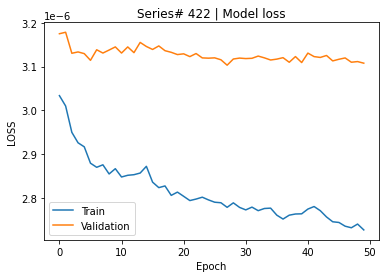

Fit for series: ['FOODS_1_123' 'FOODS_1' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_012' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['FOODS_2_311' 'FOODS_2' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_1_159' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_2_072' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_1_304' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_3_117' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOBBIES_1_386' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']


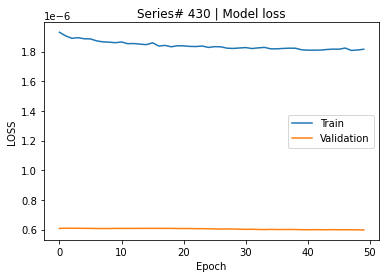

Fit for series: ['HOUSEHOLD_1_096' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_1_499' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_243' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_3' 'CA']


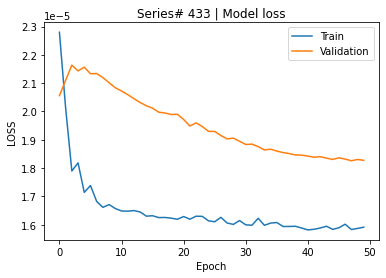

Fit for series: ['FOODS_3_141' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['FOODS_2_399' 'FOODS_2' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_2_172' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_3' 'TX']


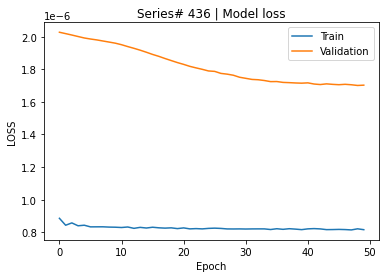

Fit for series: ['FOODS_1_194' 'FOODS_1' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOBBIES_1_392' 'HOBBIES_1' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_1_429' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_312' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_355' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOBBIES_1_290' 'HOBBIES_1' 'HOBBIES' 'WI_1' 'WI']
Fit for series: ['FOODS_3_385' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['FOODS_3_180' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_1_026' 'FOODS_1' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_3_518' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_3_357' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_1_528' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['FOODS_3_525' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_1_074' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_330' 'HOUSEHOLD_2' 'HOUSEHOLD'

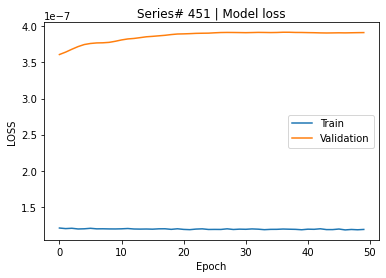

Fit for series: ['HOUSEHOLD_2_088' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOBBIES_1_379' 'HOBBIES_1' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['FOODS_2_366' 'FOODS_2' 'FOODS' 'CA_4' 'CA']
Fit for series: ['FOODS_2_345' 'FOODS_2' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_025' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_2_147' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_3_457' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOBBIES_1_385' 'HOBBIES_1' 'HOBBIES' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_438' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['FOODS_1_023' 'FOODS_1' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_2_316' 'FOODS_2' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_364' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['FOODS_2_114' 'FOODS_2' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_371' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_1_359' 'HOUSEHOLD_1'

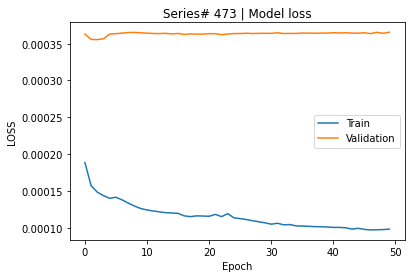

Fit for series: ['FOODS_3_034' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_1_193' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']


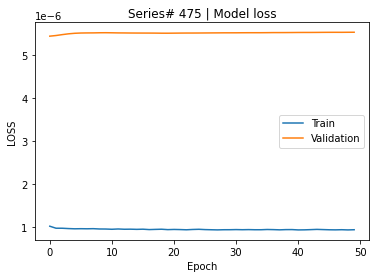

Fit for series: ['FOODS_3_768' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_3_622' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOBBIES_2_107' 'HOBBIES_2' 'HOBBIES' 'WI_2' 'WI']
Fit for series: ['HOBBIES_2_032' 'HOBBIES_2' 'HOBBIES' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_1_227' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['FOODS_3_031' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOBBIES_2_023' 'HOBBIES_2' 'HOBBIES' 'TX_1' 'TX']
Fit for series: ['FOODS_3_660' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOBBIES_1_206' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['HOBBIES_2_014' 'HOBBIES_2' 'HOBBIES' 'TX_1' 'TX']


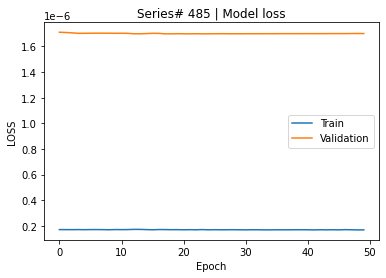

Fit for series: ['FOODS_3_154' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_2_145' 'FOODS_2' 'FOODS' 'TX_1' 'TX']
Fit for series: ['FOODS_1_014' 'FOODS_1' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_1_010' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_2_183' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOBBIES_1_156' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_1_404' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']


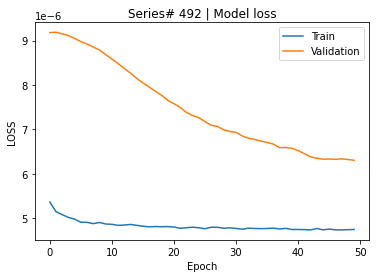

Fit for series: ['HOBBIES_1_047' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']


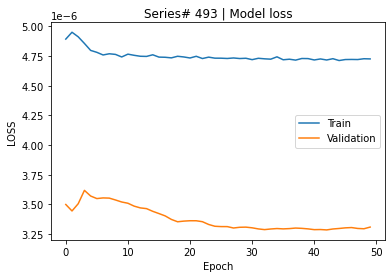

Fit for series: ['FOODS_3_447' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOBBIES_1_235' 'HOBBIES_1' 'HOBBIES' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_433' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['FOODS_3_015' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_1_249' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['HOBBIES_2_120' 'HOBBIES_2' 'HOBBIES' 'CA_2' 'CA']


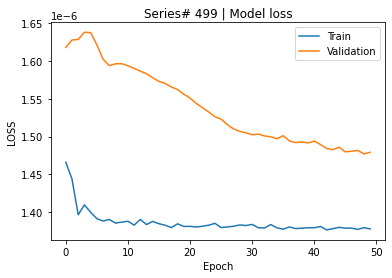

Fit for series: ['HOUSEHOLD_1_328' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['FOODS_2_352' 'FOODS_2' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOBBIES_1_011' 'HOBBIES_1' 'HOBBIES' 'TX_3' 'TX']
Fit for series: ['FOODS_3_459' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_3_268' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_1_092' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOBBIES_2_060' 'HOBBIES_2' 'HOBBIES' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_2_342' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['HOBBIES_1_027' 'HOBBIES_1' 'HOBBIES' 'TX_3' 'TX']
Fit for series: ['FOODS_1_118' 'FOODS_1' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_3_366' 'FOODS_3' 'FOODS' 'CA_1' 'CA']


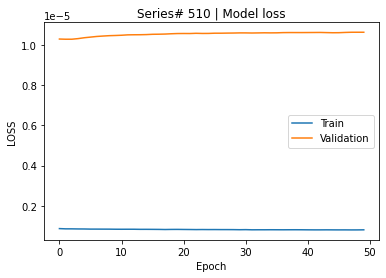

Fit for series: ['HOUSEHOLD_2_019' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['FOODS_1_120' 'FOODS_1' 'FOODS' 'WI_1' 'WI']
Fit for series: ['FOODS_2_168' 'FOODS_2' 'FOODS' 'TX_1' 'TX']
Fit for series: ['FOODS_3_222' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_3_398' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_016' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_2_223' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['FOODS_1_083' 'FOODS_1' 'FOODS' 'TX_1' 'TX']
Fit for series: ['FOODS_2_268' 'FOODS_2' 'FOODS' 'CA_2' 'CA']


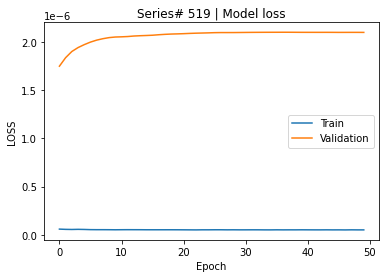

Fit for series: ['FOODS_3_739' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['FOODS_2_071' 'FOODS_2' 'FOODS' 'WI_2' 'WI']
Fit for series: ['FOODS_3_577' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_115' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['FOODS_2_017' 'FOODS_2' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_3_027' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_1_023' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['FOODS_2_089' 'FOODS_2' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_2_069' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_460' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_386' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['FOODS_3_343' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_2_062' 'FOODS_2' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOBBIES_1_266' 'HOBBIES_1' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['FOODS_3_059' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit 

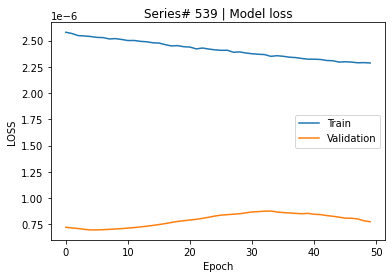

Fit for series: ['HOBBIES_1_132' 'HOBBIES_1' 'HOBBIES' 'TX_1' 'TX']
Fit for series: ['FOODS_3_293' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_3_416' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOBBIES_2_120' 'HOBBIES_2' 'HOBBIES' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_2_487' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_1_417' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_438' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_1_297' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_1_185' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_2' 'CA']


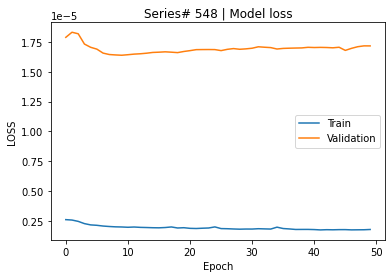

Fit for series: ['HOUSEHOLD_2_230' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_1_128' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['FOODS_2_279' 'FOODS_2' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_2_189' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOBBIES_1_217' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['FOODS_3_015' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_2_370' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['HOBBIES_1_104' 'HOBBIES_1' 'HOBBIES' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_1_100' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['HOBBIES_1_003' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_1_046' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['HOBBIES_1_043' 'HOBBIES_1' 'HOBBIES' 'CA_4' 'CA']
Fit for series: ['FOODS_2_295' 'FOODS_2' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_2_433' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOUSEH

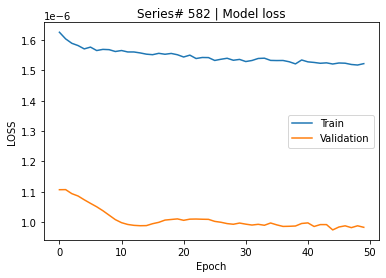

Fit for series: ['FOODS_3_020' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['FOODS_3_514' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOBBIES_1_069' 'HOBBIES_1' 'HOBBIES' 'CA_4' 'CA']
Fit for series: ['FOODS_3_455' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_1_406' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_281' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOBBIES_1_281' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']
Fit for series: ['HOBBIES_1_157' 'HOBBIES_1' 'HOBBIES' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_1_460' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['FOODS_1_068' 'FOODS_1' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_3_477' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['FOODS_2_090' 'FOODS_2' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_1_243' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_257' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_1_167' 'HOUSEHOLD_1' 'HOUS

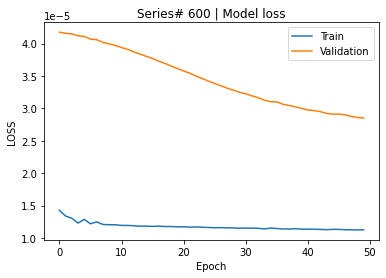

Fit for series: ['FOODS_3_223' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_178' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']


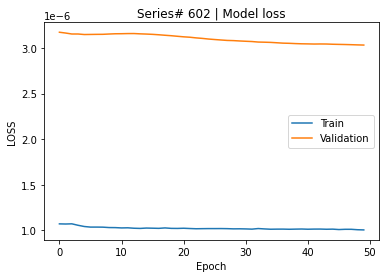

Fit for series: ['HOUSEHOLD_2_214' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_3_680' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['FOODS_2_050' 'FOODS_2' 'FOODS' 'CA_3' 'CA']
Fit for series: ['FOODS_3_153' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_385' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['FOODS_3_566' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_3_486' 'FOODS_3' 'FOODS' 'CA_2' 'CA']


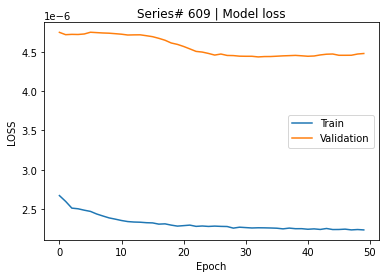

Fit for series: ['HOUSEHOLD_1_009' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_1_097' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']


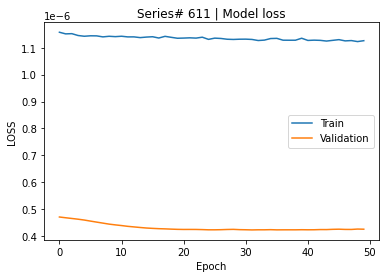

Fit for series: ['HOBBIES_1_197' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']
Fit for series: ['FOODS_1_187' 'FOODS_1' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_3_519' 'FOODS_3' 'FOODS' 'CA_2' 'CA']


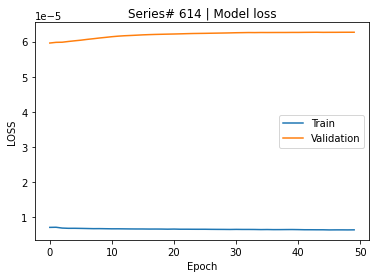

Fit for series: ['FOODS_1_091' 'FOODS_1' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_332' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_2_073' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['FOODS_1_036' 'FOODS_1' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_1_258' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['FOODS_3_200' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_1_520' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_2_408' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_1_272' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['FOODS_3_601' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['FOODS_3_198' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_3_690' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_1_085' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['FOODS_2_320' 'FOODS_2' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_1_295' 'HOUSEHOLD_1'

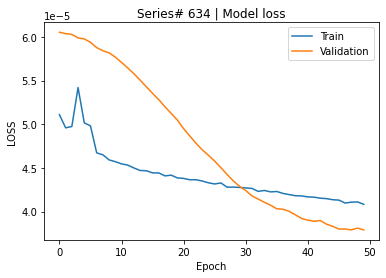

Fit for series: ['HOUSEHOLD_2_278' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_215' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['FOODS_2_141' 'FOODS_2' 'FOODS' 'WI_2' 'WI']
Fit for series: ['FOODS_1_072' 'FOODS_1' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_2_011' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']


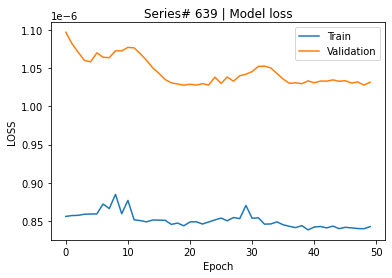

Fit for series: ['HOUSEHOLD_2_105' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['FOODS_1_032' 'FOODS_1' 'FOODS' 'WI_2' 'WI']
Fit for series: ['FOODS_3_168' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOBBIES_1_274' 'HOBBIES_1' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['FOODS_2_341' 'FOODS_2' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_2_287' 'FOODS_2' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_2_121' 'FOODS_2' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOBBIES_2_081' 'HOBBIES_2' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['HOBBIES_1_028' 'HOBBIES_1' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['HOBBIES_1_417' 'HOBBIES_1' 'HOBBIES' 'WI_2' 'WI']
Fit for series: ['FOODS_3_347' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['FOODS_1_039' 'FOODS_1' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOBBIES_1_374' 'HOBBIES_1' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_2_463' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOBBIES_2_108' 'HOBBIES_2' 'HOBBIES' 'CA_2' 'CA']
Fit for se

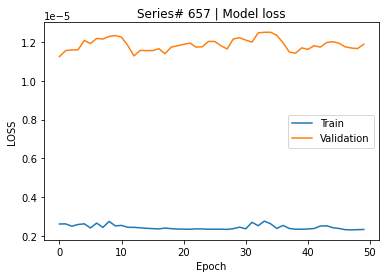

Fit for series: ['HOBBIES_1_034' 'HOBBIES_1' 'HOBBIES' 'TX_1' 'TX']
Fit for series: ['FOODS_3_811' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_2_490' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['FOODS_3_676' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_052' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_2_115' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_1_411' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['FOODS_1_053' 'FOODS_1' 'FOODS' 'TX_1' 'TX']
Fit for series: ['FOODS_1_107' 'FOODS_1' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOBBIES_2_009' 'HOBBIES_2' 'HOBBIES' 'CA_2' 'CA']
Fit for series: ['HOBBIES_1_089' 'HOBBIES_1' 'HOBBIES' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_1_134' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOBBIES_1_225' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_1_004' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOBBIES_2_139' 'HO

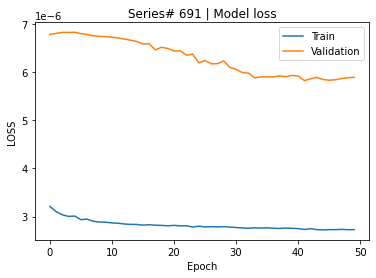

Fit for series: ['HOUSEHOLD_2_260' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['FOODS_2_159' 'FOODS_2' 'FOODS' 'CA_4' 'CA']
Fit for series: ['FOODS_2_200' 'FOODS_2' 'FOODS' 'TX_3' 'TX']
Fit for series: ['FOODS_3_488' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_2_153' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['FOODS_2_390' 'FOODS_2' 'FOODS' 'CA_4' 'CA']
Fit for series: ['FOODS_2_097' 'FOODS_2' 'FOODS' 'CA_4' 'CA']
Fit for series: ['FOODS_1_049' 'FOODS_1' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOBBIES_1_349' 'HOBBIES_1' 'HOBBIES' 'WI_2' 'WI']
Fit for series: ['FOODS_2_095' 'FOODS_2' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_1_285' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_141' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_115' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOBBIES_1_370' 'HOBBIES_1' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_1_143' 'HOUSEHOLD_1' 'HOUSEHOLD'

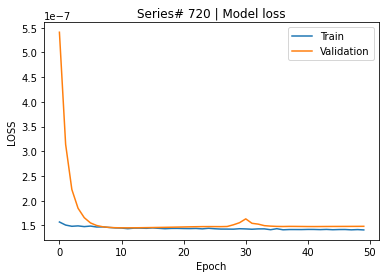

Fit for series: ['HOUSEHOLD_1_134' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_308' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOBBIES_1_110' 'HOBBIES_1' 'HOBBIES' 'TX_1' 'TX']


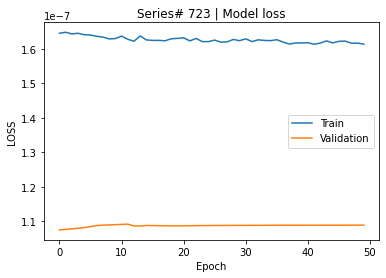

Fit for series: ['HOUSEHOLD_1_304' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_2_469' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_163' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']


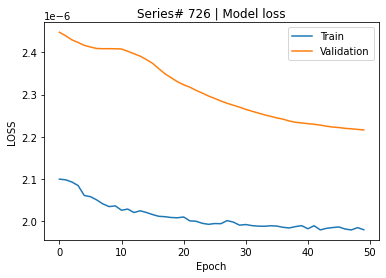

Fit for series: ['FOODS_3_768' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['FOODS_2_231' 'FOODS_2' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_529' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_208' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_2_149' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_1_535' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_1_369' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']


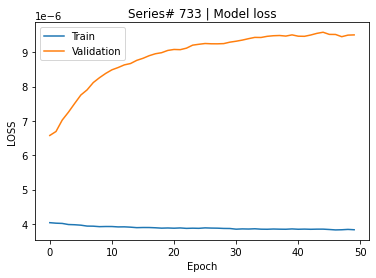

Fit for series: ['HOBBIES_1_349' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_1_148' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_1_006' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['FOODS_1_094' 'FOODS_1' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOBBIES_2_045' 'HOBBIES_2' 'HOBBIES' 'CA_4' 'CA']
Fit for series: ['FOODS_3_793' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['FOODS_3_004' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_187' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['FOODS_3_635' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_1_430' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_424' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['FOODS_1_085' 'FOODS_1' 'FOODS' 'CA_3' 'CA']
Fit for series: ['FOODS_3_567' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_2_182' 'FOODS_2' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_3_320' 'FOODS_3' 'FOODS' 'WI_2' 'WI'

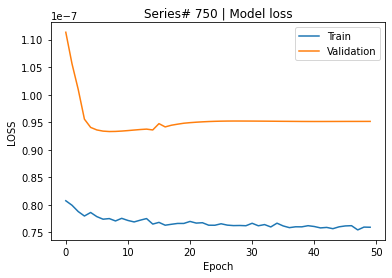

Fit for series: ['HOUSEHOLD_2_322' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']


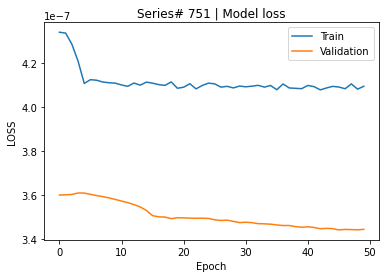

Fit for series: ['HOUSEHOLD_2_349' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOBBIES_1_276' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_1_506' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['FOODS_3_205' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['FOODS_2_396' 'FOODS_2' 'FOODS' 'WI_2' 'WI']
Fit for series: ['FOODS_1_098' 'FOODS_1' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOBBIES_1_164' 'HOBBIES_1' 'HOBBIES' 'CA_1' 'CA']
Fit for series: ['HOBBIES_1_154' 'HOBBIES_1' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['FOODS_1_066' 'FOODS_1' 'FOODS' 'TX_3' 'TX']


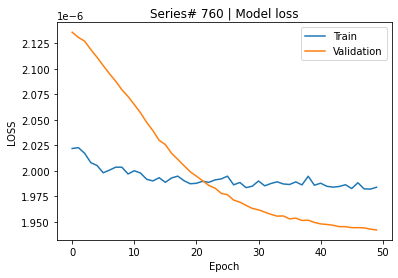

Fit for series: ['HOBBIES_1_133' 'HOBBIES_1' 'HOBBIES' 'TX_3' 'TX']
Fit for series: ['FOODS_3_409' 'FOODS_3' 'FOODS' 'TX_2' 'TX']


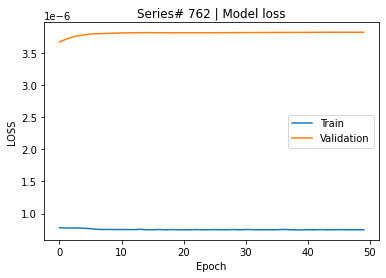

Fit for series: ['FOODS_3_774' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOBBIES_1_075' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['FOODS_2_287' 'FOODS_2' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_037' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_498' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']


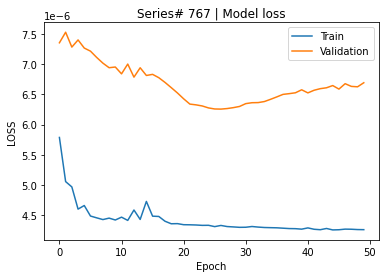

Fit for series: ['FOODS_1_002' 'FOODS_1' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_1_505' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['FOODS_3_360' 'FOODS_3' 'FOODS' 'TX_2' 'TX']


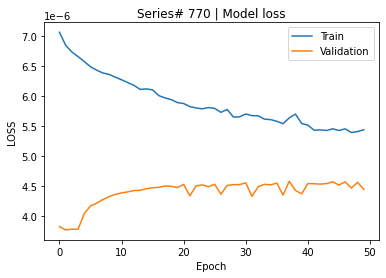

Fit for series: ['FOODS_1_020' 'FOODS_1' 'FOODS' 'TX_1' 'TX']
Fit for series: ['FOODS_3_184' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOBBIES_2_004' 'HOBBIES_2' 'HOBBIES' 'TX_3' 'TX']
Fit for series: ['FOODS_2_135' 'FOODS_2' 'FOODS' 'TX_3' 'TX']
Fit for series: ['FOODS_3_750' 'FOODS_3' 'FOODS' 'WI_3' 'WI']


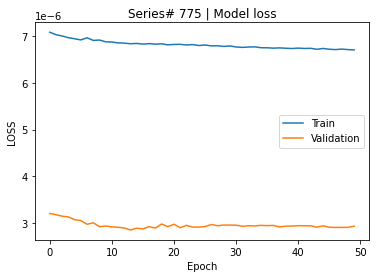

Fit for series: ['HOBBIES_1_418' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['FOODS_3_405' 'FOODS_3' 'FOODS' 'CA_1' 'CA']


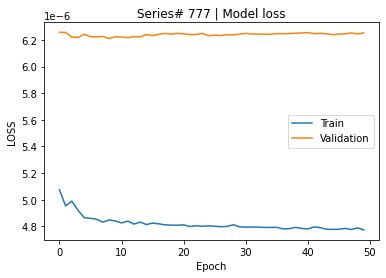

Fit for series: ['FOODS_3_631' 'FOODS_3' 'FOODS' 'CA_3' 'CA']


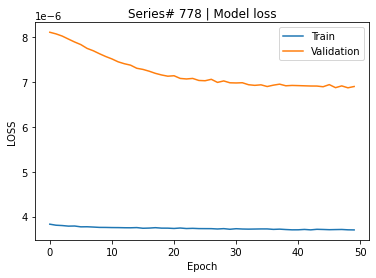

Fit for series: ['HOBBIES_1_318' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']
Fit for series: ['FOODS_2_303' 'FOODS_2' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_1_457' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_1_468' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['FOODS_3_490' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['FOODS_3_001' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_1_211' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['FOODS_2_320' 'FOODS_2' 'FOODS' 'WI_1' 'WI']
Fit for series: ['FOODS_3_131' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_2_251' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_2_238' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']


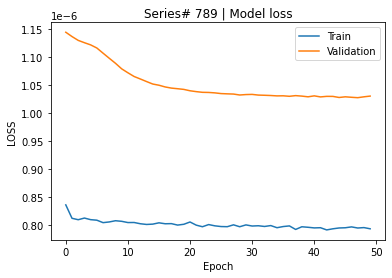

Fit for series: ['FOODS_2_359' 'FOODS_2' 'FOODS' 'WI_1' 'WI']


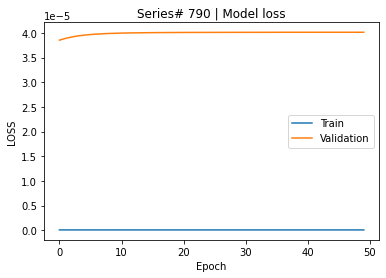

Fit for series: ['HOUSEHOLD_1_209' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_2_395' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_1_415' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_2_127' 'FOODS_2' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOBBIES_1_419' 'HOBBIES_1' 'HOBBIES' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_2_235' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_026' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOBBIES_1_203' 'HOBBIES_1' 'HOBBIES' 'WI_1' 'WI']
Fit for series: ['HOBBIES_1_172' 'HOBBIES_1' 'HOBBIES' 'CA_4' 'CA']
Fit for series: ['HOBBIES_2_080' 'HOBBIES_2' 'HOBBIES' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_1_514' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['FOODS_3_703' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOBBIES_1_193' 'HOBBIES_1' 'HOBBIES' 'WI_3' 'WI']


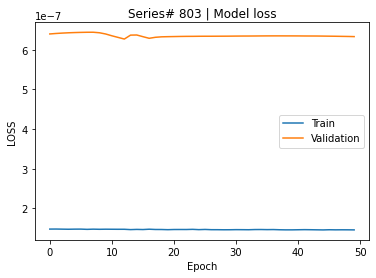

Fit for series: ['HOUSEHOLD_2_289' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']


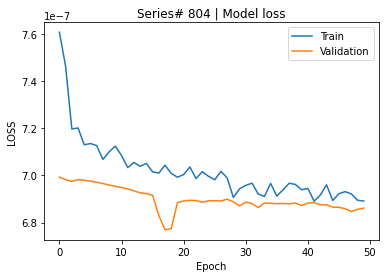

Fit for series: ['HOUSEHOLD_1_382' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['FOODS_1_141' 'FOODS_1' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_348' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_1_443' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['FOODS_1_195' 'FOODS_1' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOBBIES_1_151' 'HOBBIES_1' 'HOBBIES' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_2_286' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_2_211' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['FOODS_3_102' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_1_196' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_1_257' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['FOODS_3_646' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_505' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_249' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['

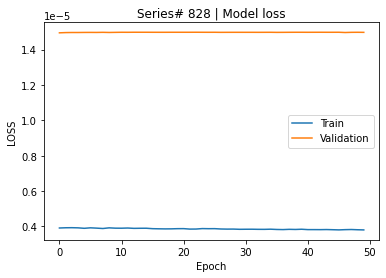

Fit for series: ['FOODS_3_496' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_2_329' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['HOBBIES_1_378' 'HOBBIES_1' 'HOBBIES' 'WI_2' 'WI']
Fit for series: ['HOBBIES_1_129' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']


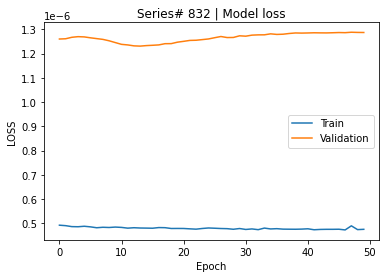

Fit for series: ['FOODS_3_555' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_254' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_1' 'WI']


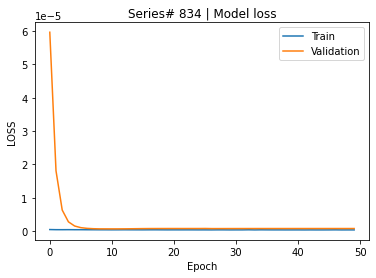

Fit for series: ['HOBBIES_1_290' 'HOBBIES_1' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['HOBBIES_1_043' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['FOODS_3_644' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_2_337' 'FOODS_2' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_1_085' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_2' 'CA']


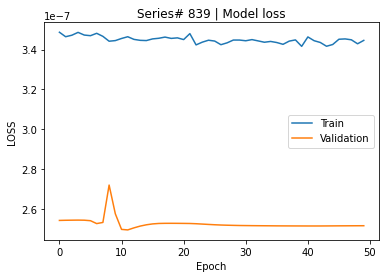

Fit for series: ['HOUSEHOLD_1_072' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['FOODS_2_077' 'FOODS_2' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_3_825' 'FOODS_3' 'FOODS' 'CA_4' 'CA']


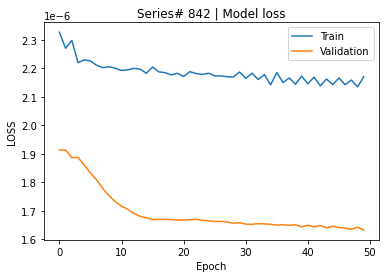

Fit for series: ['HOBBIES_1_027' 'HOBBIES_1' 'HOBBIES' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_1_251' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['FOODS_3_208' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_2_165' 'FOODS_2' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_1_412' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['FOODS_3_443' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['FOODS_3_742' 'FOODS_3' 'FOODS' 'TX_1' 'TX']


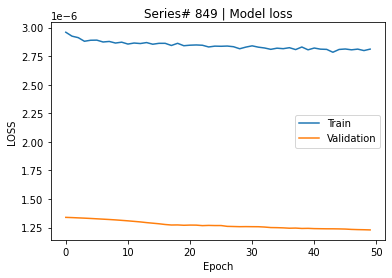

Fit for series: ['HOUSEHOLD_1_199' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['FOODS_3_480' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_3_556' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_3_303' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_362' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_2_328' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_445' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']


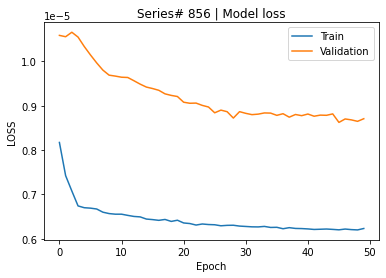

Fit for series: ['HOBBIES_1_345' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['FOODS_1_005' 'FOODS_1' 'FOODS' 'CA_3' 'CA']
Fit for series: ['FOODS_3_087' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['FOODS_3_511' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['FOODS_2_349' 'FOODS_2' 'FOODS' 'CA_4' 'CA']


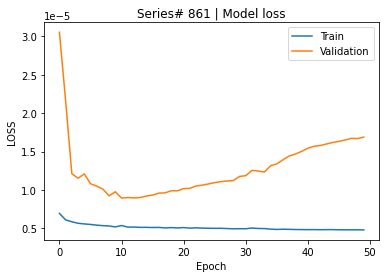

Fit for series: ['HOBBIES_1_152' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']
Fit for series: ['HOBBIES_2_129' 'HOBBIES_2' 'HOBBIES' 'TX_1' 'TX']
Fit for series: ['HOBBIES_1_011' 'HOBBIES_1' 'HOBBIES' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_1_224' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_401' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['FOODS_3_068' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_3_801' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['FOODS_1_002' 'FOODS_1' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_3_509' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['FOODS_3_225' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_1_271' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']


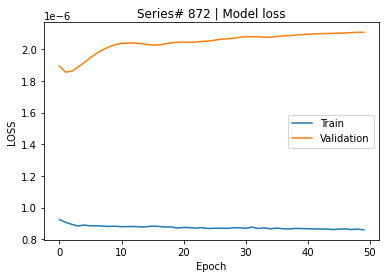

Fit for series: ['HOUSEHOLD_1_456' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_2_261' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_2_262' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_111' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['FOODS_2_320' 'FOODS_2' 'FOODS' 'TX_1' 'TX']


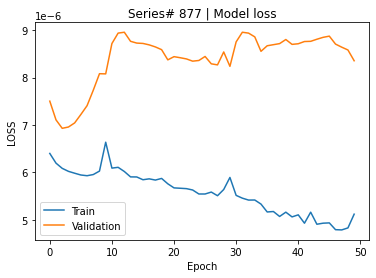

Fit for series: ['HOUSEHOLD_1_295' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']


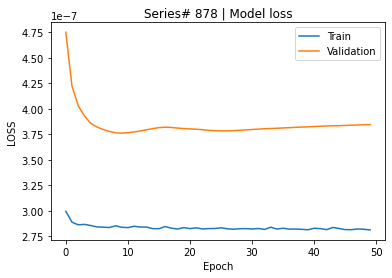

Fit for series: ['HOUSEHOLD_1_327' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_2_226' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']


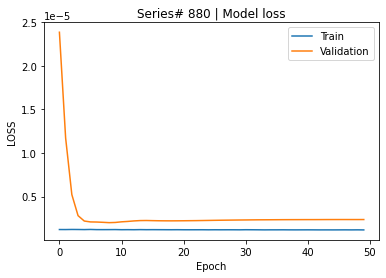

Fit for series: ['HOBBIES_1_337' 'HOBBIES_1' 'HOBBIES' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_2_425' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['FOODS_2_074' 'FOODS_2' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_459' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']


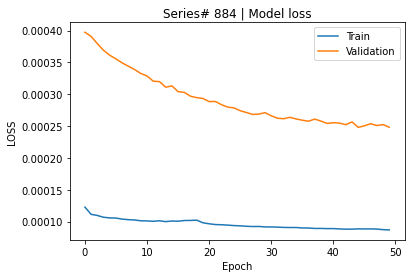

Fit for series: ['FOODS_3_143' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_3_214' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_474' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['FOODS_3_099' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_3_280' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_3_243' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOBBIES_1_225' 'HOBBIES_1' 'HOBBIES' 'TX_3' 'TX']
Fit for series: ['FOODS_3_623' 'FOODS_3' 'FOODS' 'CA_1' 'CA']


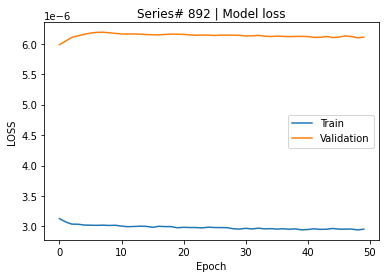

Fit for series: ['HOBBIES_1_209' 'HOBBIES_1' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_159' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_1_364' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['FOODS_2_060' 'FOODS_2' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_2_119' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_531' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['FOODS_1_041' 'FOODS_1' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOBBIES_1_253' 'HOBBIES_1' 'HOBBIES' 'WI_1' 'WI']
Fit for series: ['FOODS_3_465' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_3_478' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['FOODS_1_166' 'FOODS_1' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_3_659' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOBBIES_1_265' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']
Fit for series: ['FOODS_2_349' 'FOODS_2' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_3_469' 'FOODS_3' 'FOODS' 'TX_1' 'TX']


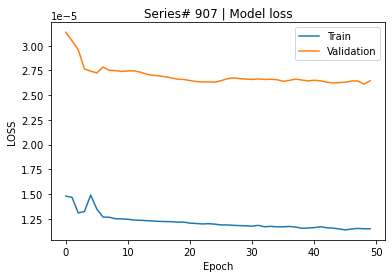

Fit for series: ['FOODS_1_211' 'FOODS_1' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_241' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['HOBBIES_2_028' 'HOBBIES_2' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['FOODS_2_124' 'FOODS_2' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_235' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_1_183' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_2_364' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_2_286' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_1_312' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['FOODS_2_187' 'FOODS_2' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_2_142' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_1_173' 'FOODS_1' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOBBIES_2_149' 'HOBBIES_2' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_045' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['FOODS_

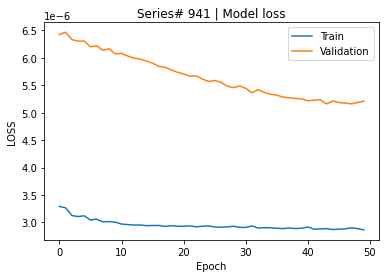

Fit for series: ['FOODS_2_018' 'FOODS_2' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_1_091' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['FOODS_3_349' 'FOODS_3' 'FOODS' 'TX_2' 'TX']


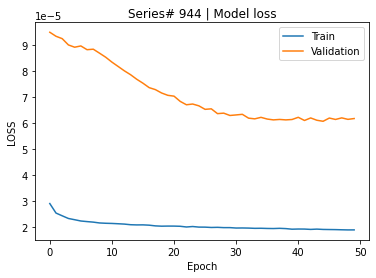

Fit for series: ['HOBBIES_1_225' 'HOBBIES_1' 'HOBBIES' 'CA_4' 'CA']
Fit for series: ['FOODS_3_144' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOBBIES_1_397' 'HOBBIES_1' 'HOBBIES' 'TX_3' 'TX']
Fit for series: ['FOODS_3_819' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['FOODS_3_398' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_2_481' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_199' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']


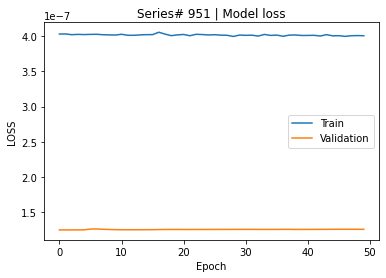

Fit for series: ['HOUSEHOLD_2_190' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_519' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_1_137' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_307' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_1_528' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_1_054' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_101' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_033' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['FOODS_3_723' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_2_049' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['FOODS_2_320' 'FOODS_2' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOBBIES_1_158' 'HOBBIES_1' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['HOBBIES_1_060' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_1_540' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_2' 'CA']


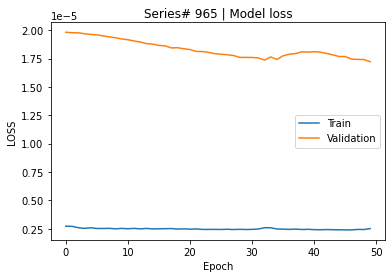

Fit for series: ['HOBBIES_1_339' 'HOBBIES_1' 'HOBBIES' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_117' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOBBIES_1_274' 'HOBBIES_1' 'HOBBIES' 'CA_4' 'CA']
Fit for series: ['FOODS_3_772' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['FOODS_1_158' 'FOODS_1' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_058' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['FOODS_3_006' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['FOODS_1_034' 'FOODS_1' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_2_323' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['FOODS_3_802' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_2_457' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_1_029' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOBBIES_1_279' 'HOBBIES_1' 'HOBBIES' 'WI_1' 'WI']


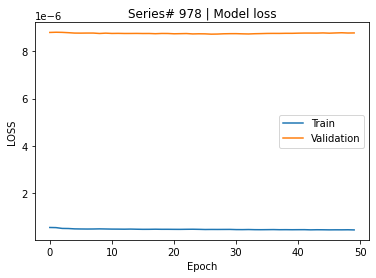

Fit for series: ['HOBBIES_1_204' 'HOBBIES_1' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['FOODS_3_044' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_1_015' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_267' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_052' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOBBIES_2_110' 'HOBBIES_2' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_1_190' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_1_219' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['FOODS_3_697' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOBBIES_2_136' 'HOBBIES_2' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['HOBBIES_1_200' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_2_504' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['FOODS_3_434' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_2_417' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['FOODS_

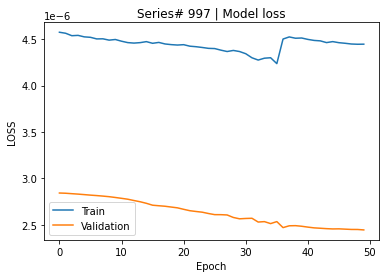

Fit for series: ['HOUSEHOLD_1_323' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['FOODS_3_663' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_1_075' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['FOODS_3_577' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_170' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_2_134' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['FOODS_2_298' 'FOODS_2' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOBBIES_1_023' 'HOBBIES_1' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['FOODS_3_403' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_1_325' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_1_488' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_460' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['FOODS_3_072' 'FOODS_3' 'FOODS' 'CA_2' 'CA']


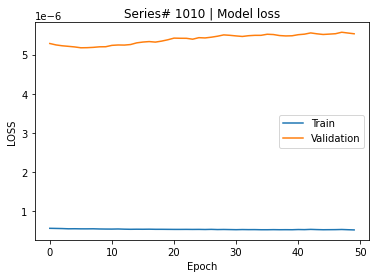

Fit for series: ['HOUSEHOLD_2_097' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['FOODS_1_111' 'FOODS_1' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_3_640' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_3_070' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_1_140' 'FOODS_1' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOBBIES_1_368' 'HOBBIES_1' 'HOBBIES' 'CA_1' 'CA']
Fit for series: ['HOBBIES_1_001' 'HOBBIES_1' 'HOBBIES' 'WI_1' 'WI']
Fit for series: ['HOBBIES_1_107' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']
Fit for series: ['FOODS_2_256' 'FOODS_2' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_3_538' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_1_502' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_2_234' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOBBIES_2_023' 'HOBBIES_2' 'HOBBIES' 'TX_3' 'TX']


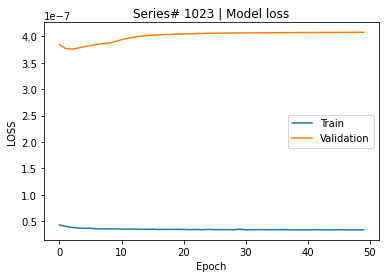

Fit for series: ['FOODS_2_280' 'FOODS_2' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_1_280' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOBBIES_1_303' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']
Fit for series: ['FOODS_2_202' 'FOODS_2' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_3_820' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_1_154' 'FOODS_1' 'FOODS' 'WI_1' 'WI']


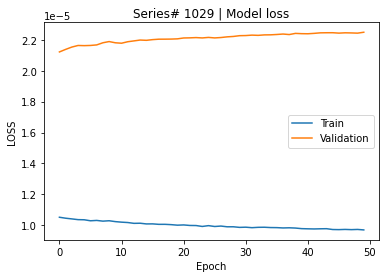

Fit for series: ['FOODS_1_096' 'FOODS_1' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_361' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['FOODS_3_439' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['FOODS_2_064' 'FOODS_2' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_303' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['FOODS_2_050' 'FOODS_2' 'FOODS' 'TX_3' 'TX']
Fit for series: ['FOODS_3_416' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_306' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['FOODS_3_779' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['FOODS_2_265' 'FOODS_2' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_2_009' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['FOODS_1_154' 'FOODS_1' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_2_100' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_486' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_2_040' 'HOUSEHOLD_2' 'HOUSEHOLD'

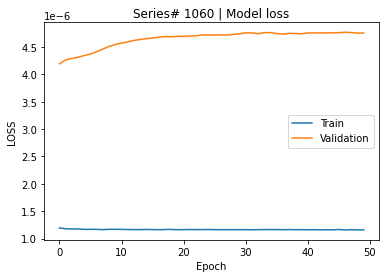

Fit for series: ['HOBBIES_1_276' 'HOBBIES_1' 'HOBBIES' 'CA_4' 'CA']
Fit for series: ['FOODS_3_642' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['FOODS_3_133' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_3_417' 'FOODS_3' 'FOODS' 'CA_2' 'CA']


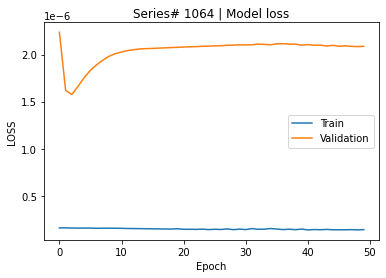

Fit for series: ['HOBBIES_1_136' 'HOBBIES_1' 'HOBBIES' 'CA_4' 'CA']
Fit for series: ['HOBBIES_1_112' 'HOBBIES_1' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['HOBBIES_1_290' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['FOODS_2_295' 'FOODS_2' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_113' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['FOODS_2_330' 'FOODS_2' 'FOODS' 'WI_1' 'WI']
Fit for series: ['FOODS_3_583' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['FOODS_2_029' 'FOODS_2' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_1_018' 'FOODS_1' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_3_692' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_1_181' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_452' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['FOODS_2_127' 'FOODS_2' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_200' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_2_359' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_1

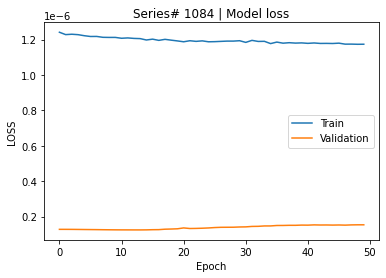

Fit for series: ['FOODS_3_408' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['FOODS_3_238' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_1_320' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_1_127' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']


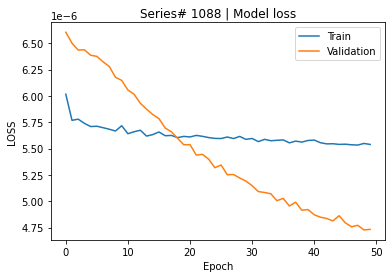

Fit for series: ['HOUSEHOLD_1_498' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['FOODS_3_798' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['FOODS_3_479' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOBBIES_2_066' 'HOBBIES_2' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['FOODS_3_671' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_1_505' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOBBIES_1_034' 'HOBBIES_1' 'HOBBIES' 'CA_1' 'CA']
Fit for series: ['FOODS_3_303' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_1_405' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_188' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_2_086' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['FOODS_2_007' 'FOODS_2' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOBBIES_1_085' 'HOBBIES_1' 'HOBBIES' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_216' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['FOODS_1_121' 'FOODS_1' '

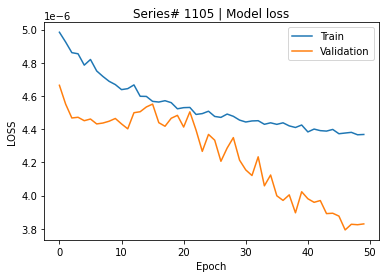

Fit for series: ['HOUSEHOLD_1_089' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOBBIES_1_393' 'HOBBIES_1' 'HOBBIES' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_2_130' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['FOODS_3_766' 'FOODS_3' 'FOODS' 'CA_3' 'CA']


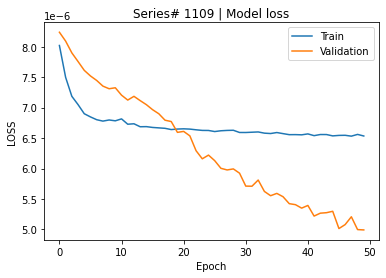

Fit for series: ['HOBBIES_2_007' 'HOBBIES_2' 'HOBBIES' 'WI_2' 'WI']
Fit for series: ['HOBBIES_1_126' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['FOODS_3_171' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOBBIES_1_200' 'HOBBIES_1' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['FOODS_3_419' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_3_071' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_3_163' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOBBIES_1_220' 'HOBBIES_1' 'HOBBIES' 'TX_1' 'TX']
Fit for series: ['FOODS_1_033' 'FOODS_1' 'FOODS' 'TX_3' 'TX']
Fit for series: ['FOODS_2_334' 'FOODS_2' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_1_190' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['HOBBIES_1_187' 'HOBBIES_1' 'HOBBIES' 'CA_1' 'CA']
Fit for series: ['HOBBIES_1_117' 'HOBBIES_1' 'HOBBIES' 'WI_2' 'WI']
Fit for series: ['HOBBIES_1_227' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_1_522' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']


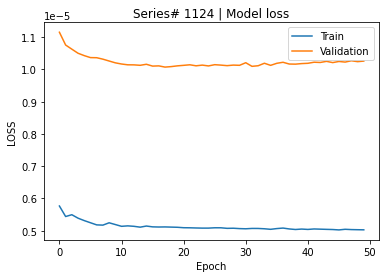

Fit for series: ['HOBBIES_1_270' 'HOBBIES_1' 'HOBBIES' 'WI_2' 'WI']
Fit for series: ['FOODS_3_483' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_3_821' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_2_323' 'FOODS_2' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOBBIES_1_125' 'HOBBIES_1' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_1_533' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']


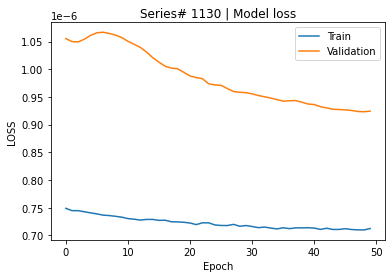

Fit for series: ['HOUSEHOLD_2_152' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_2_017' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_2_229' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_250' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['FOODS_3_720' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['FOODS_3_226' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_1_177' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['HOBBIES_2_003' 'HOBBIES_2' 'HOBBIES' 'TX_1' 'TX']
Fit for series: ['FOODS_3_573' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOBBIES_1_255' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_2_187' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['HOBBIES_1_087' 'HOBBIES_1' 'HOBBIES' 'WI_1' 'WI']
Fit for series: ['FOODS_3_513' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOBBIES_1_241' 'HOBBIES_1' 'HOBBIES' 'TX_3' 'TX']


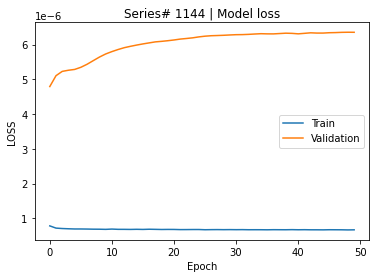

Fit for series: ['FOODS_3_188' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOBBIES_1_368' 'HOBBIES_1' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['FOODS_2_314' 'FOODS_2' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_1_474' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['FOODS_1_026' 'FOODS_1' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_492' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['FOODS_2_050' 'FOODS_2' 'FOODS' 'CA_4' 'CA']
Fit for series: ['FOODS_2_005' 'FOODS_2' 'FOODS' 'WI_1' 'WI']
Fit for series: ['FOODS_2_109' 'FOODS_2' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_493' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['FOODS_2_377' 'FOODS_2' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_1_112' 'FOODS_1' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_196' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['FOODS_3_771' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOBBIES_1_087' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']
Fit for se

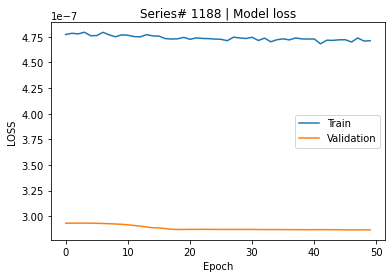

Fit for series: ['HOUSEHOLD_1_203' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOBBIES_1_358' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['FOODS_2_346' 'FOODS_2' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_2_083' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_328' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['FOODS_3_785' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_441' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']


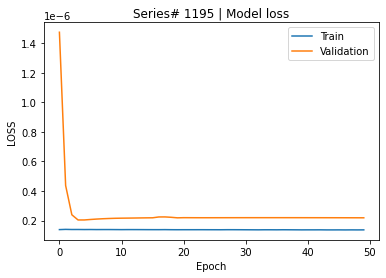

Fit for series: ['FOODS_1_207' 'FOODS_1' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_2_267' 'FOODS_2' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOBBIES_2_109' 'HOBBIES_2' 'HOBBIES' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_1_141' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOBBIES_1_093' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']
Fit for series: ['FOODS_3_339' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['FOODS_3_247' 'FOODS_3' 'FOODS' 'CA_2' 'CA']


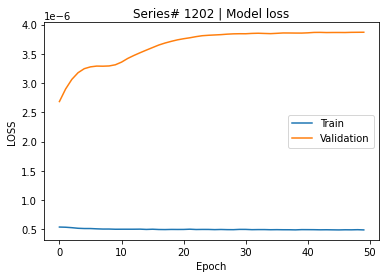

Fit for series: ['FOODS_3_122' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOBBIES_2_127' 'HOBBIES_2' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_1_011' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOBBIES_2_024' 'HOBBIES_2' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_091' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['FOODS_3_366' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['FOODS_3_721' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOBBIES_2_028' 'HOBBIES_2' 'HOBBIES' 'WI_2' 'WI']
Fit for series: ['FOODS_3_318' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_434' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_3_208' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_1_301' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']


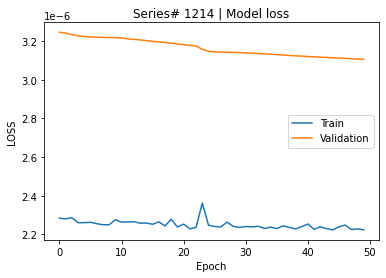

Fit for series: ['FOODS_3_813' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_1_005' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['FOODS_3_433' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOBBIES_1_089' 'HOBBIES_1' 'HOBBIES' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_508' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['FOODS_3_061' 'FOODS_3' 'FOODS' 'CA_2' 'CA']


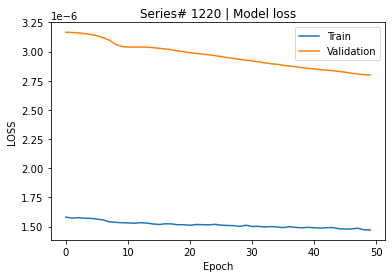

Fit for series: ['FOODS_3_577' 'FOODS_3' 'FOODS' 'TX_2' 'TX']


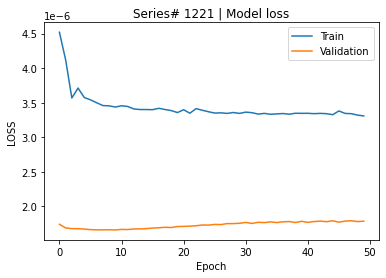

Fit for series: ['HOBBIES_1_371' 'HOBBIES_1' 'HOBBIES' 'TX_1' 'TX']
Fit for series: ['FOODS_3_138' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_2_190' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_2_510' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_2_407' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['FOODS_3_482' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['FOODS_3_241' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_3_826' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_2_010' 'FOODS_2' 'FOODS' 'CA_3' 'CA']
Fit for series: ['FOODS_3_286' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_2_215' 'FOODS_2' 'FOODS' 'CA_3' 'CA']


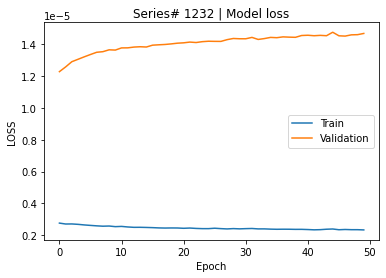

Fit for series: ['HOUSEHOLD_2_474' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_3_746' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['FOODS_3_218' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOBBIES_1_021' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']
Fit for series: ['HOBBIES_2_010' 'HOBBIES_2' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_029' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['FOODS_1_114' 'FOODS_1' 'FOODS' 'WI_2' 'WI']


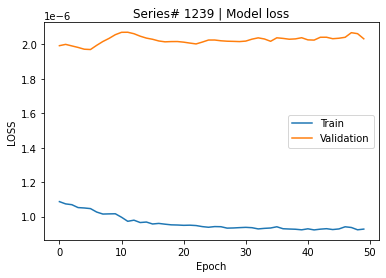

Fit for series: ['FOODS_3_005' 'FOODS_3' 'FOODS' 'CA_1' 'CA']


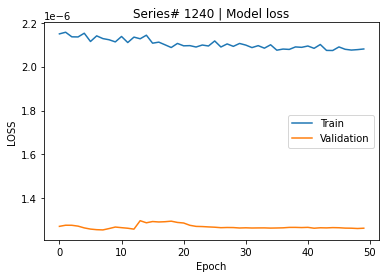

Fit for series: ['FOODS_3_808' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_3_276' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOBBIES_1_098' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['HOBBIES_1_381' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']
Fit for series: ['FOODS_1_068' 'FOODS_1' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_206' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOBBIES_1_175' 'HOBBIES_1' 'HOBBIES' 'TX_3' 'TX']


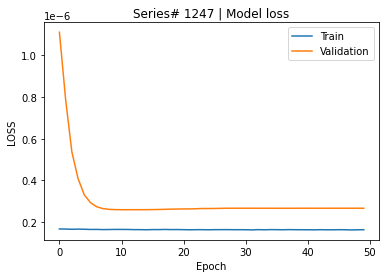

Fit for series: ['HOBBIES_1_055' 'HOBBIES_1' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['FOODS_2_040' 'FOODS_2' 'FOODS' 'TX_3' 'TX']
Fit for series: ['FOODS_3_295' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_229' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['FOODS_3_435' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_3_445' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['FOODS_3_251' 'FOODS_3' 'FOODS' 'TX_1' 'TX']


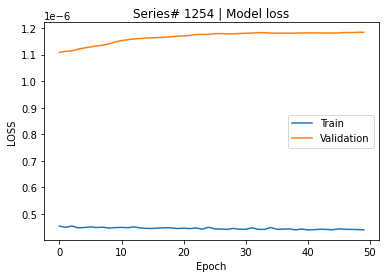

Fit for series: ['HOBBIES_1_197' 'HOBBIES_1' 'HOBBIES' 'CA_1' 'CA']
Fit for series: ['FOODS_3_706' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOBBIES_1_197' 'HOBBIES_1' 'HOBBIES' 'CA_4' 'CA']
Fit for series: ['HOBBIES_1_055' 'HOBBIES_1' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['FOODS_3_524' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['FOODS_1_022' 'FOODS_1' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_3_177' 'FOODS_3' 'FOODS' 'TX_2' 'TX']


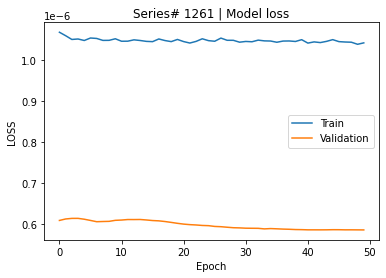

Fit for series: ['HOBBIES_1_093' 'HOBBIES_1' 'HOBBIES' 'WI_1' 'WI']
Fit for series: ['FOODS_1_203' 'FOODS_1' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_1_301' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_326' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']


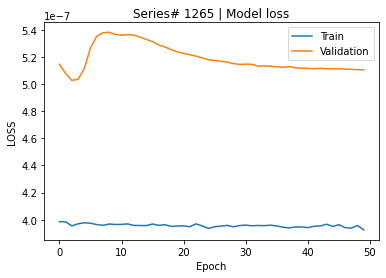

Fit for series: ['HOUSEHOLD_2_142' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_1' 'WI']


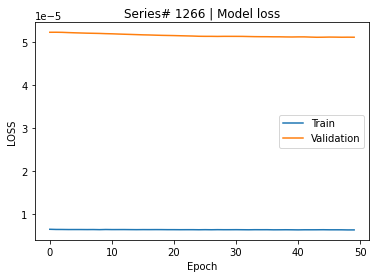

Fit for series: ['HOUSEHOLD_1_189' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOBBIES_1_045' 'HOBBIES_1' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_2_282' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['FOODS_2_087' 'FOODS_2' 'FOODS' 'TX_2' 'TX']


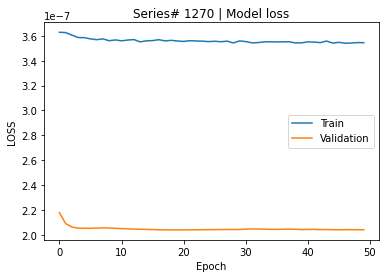

Fit for series: ['HOUSEHOLD_2_310' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_1_522' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_1_141' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_2_293' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_2_325' 'FOODS_2' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOBBIES_1_275' 'HOBBIES_1' 'HOBBIES' 'WI_3' 'WI']


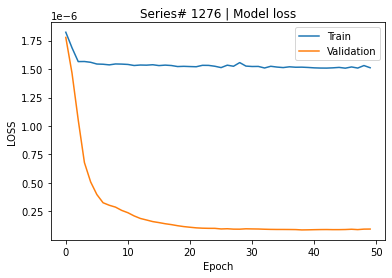

Fit for series: ['HOUSEHOLD_1_481' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['FOODS_2_142' 'FOODS_2' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_2_238' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['FOODS_3_504' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOBBIES_1_132' 'HOBBIES_1' 'HOBBIES' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_062' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOBBIES_1_346' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']
Fit for series: ['FOODS_3_581' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_2_193' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_2_312' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOBBIES_2_021' 'HOBBIES_2' 'HOBBIES' 'CA_4' 'CA']


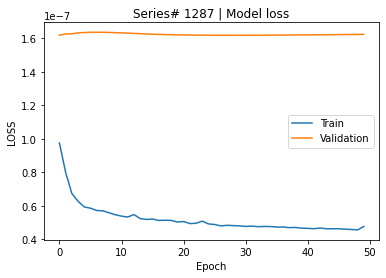

Fit for series: ['FOODS_3_126' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_2_160' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['FOODS_2_049' 'FOODS_2' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_3_237' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOBBIES_1_386' 'HOBBIES_1' 'HOBBIES' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_397' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_1_067' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_1_007' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']


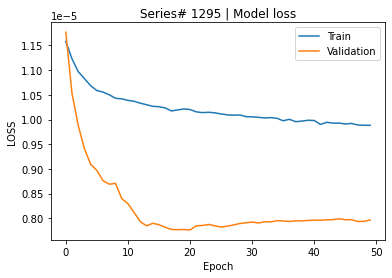

Fit for series: ['FOODS_3_686' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOBBIES_1_053' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['FOODS_3_011' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_3_782' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOBBIES_2_068' 'HOBBIES_2' 'HOBBIES' 'WI_1' 'WI']
Fit for series: ['FOODS_2_344' 'FOODS_2' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_489' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['FOODS_1_105' 'FOODS_1' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_2_136' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['FOODS_3_200' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['FOODS_3_497' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOBBIES_1_022' 'HOBBIES_1' 'HOBBIES' 'TX_2' 'TX']


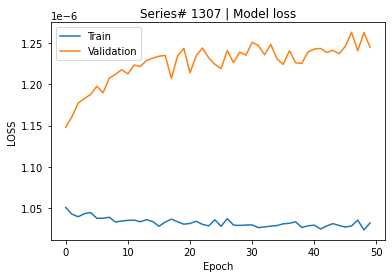

Fit for series: ['HOBBIES_1_288' 'HOBBIES_1' 'HOBBIES' 'CA_1' 'CA']
Fit for series: ['FOODS_2_095' 'FOODS_2' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_1_158' 'FOODS_1' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_2_480' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_269' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['FOODS_3_515' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_281' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_1_441' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOBBIES_2_024' 'HOBBIES_2' 'HOBBIES' 'TX_3' 'TX']
Fit for series: ['HOBBIES_1_368' 'HOBBIES_1' 'HOBBIES' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_403' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['FOODS_3_657' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_262' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['FOODS_1_012' 'FOODS_1' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_1_381' 'HOUSEH

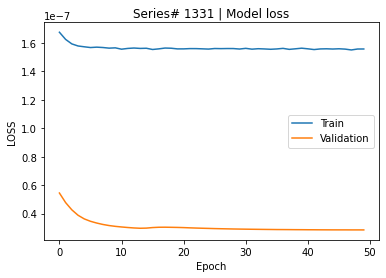

Fit for series: ['HOBBIES_1_056' 'HOBBIES_1' 'HOBBIES' 'WI_1' 'WI']
Fit for series: ['FOODS_3_815' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_164' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['FOODS_2_195' 'FOODS_2' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_1_363' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['FOODS_3_402' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_2_230' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['FOODS_3_108' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['FOODS_3_470' 'FOODS_3' 'FOODS' 'WI_2' 'WI']


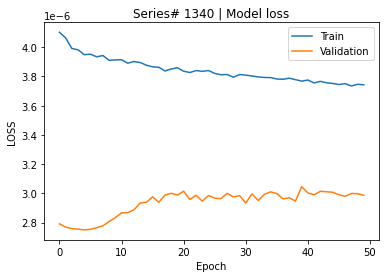

Fit for series: ['FOODS_2_145' 'FOODS_2' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_3_669' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['FOODS_2_214' 'FOODS_2' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOBBIES_1_281' 'HOBBIES_1' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['FOODS_1_025' 'FOODS_1' 'FOODS' 'CA_3' 'CA']
Fit for series: ['FOODS_1_056' 'FOODS_1' 'FOODS' 'WI_1' 'WI']


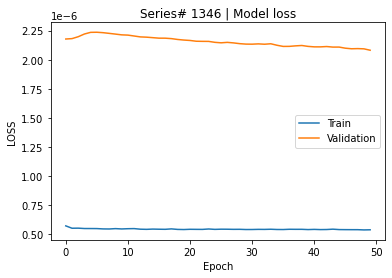

Fit for series: ['HOUSEHOLD_1_020' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['FOODS_1_001' 'FOODS_1' 'FOODS' 'WI_2' 'WI']
Fit for series: ['FOODS_2_067' 'FOODS_2' 'FOODS' 'WI_2' 'WI']
Fit for series: ['FOODS_1_014' 'FOODS_1' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOBBIES_1_228' 'HOBBIES_1' 'HOBBIES' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_1_475' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['FOODS_3_762' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_105' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_3' 'TX']


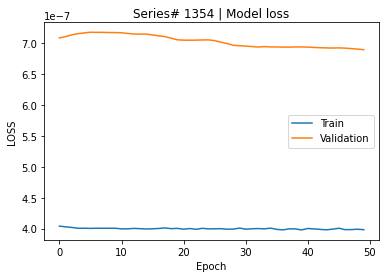

Fit for series: ['FOODS_3_204' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOBBIES_1_309' 'HOBBIES_1' 'HOBBIES' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_1_395' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_502' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['FOODS_1_195' 'FOODS_1' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOBBIES_1_036' 'HOBBIES_1' 'HOBBIES' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_229' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['FOODS_3_527' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_2_124' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']


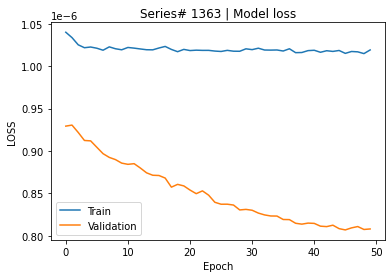

Fit for series: ['HOUSEHOLD_1_184' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['FOODS_3_716' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['FOODS_3_356' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_2_346' 'FOODS_2' 'FOODS' 'TX_1' 'TX']
Fit for series: ['FOODS_3_211' 'FOODS_3' 'FOODS' 'CA_1' 'CA']


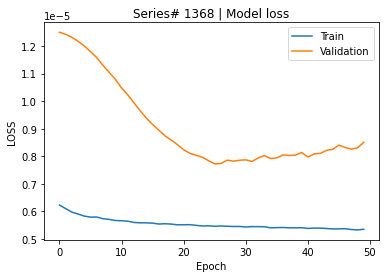

Fit for series: ['FOODS_2_103' 'FOODS_2' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_3_812' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_1_211' 'FOODS_1' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOBBIES_1_368' 'HOBBIES_1' 'HOBBIES' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_168' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_1_386' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_1_043' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_332' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']


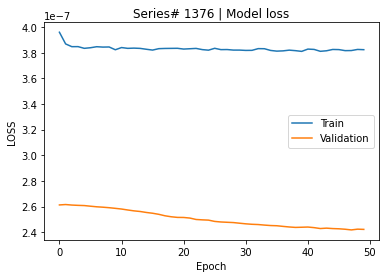

Fit for series: ['FOODS_3_378' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_2_081' 'FOODS_2' 'FOODS' 'WI_2' 'WI']
Fit for series: ['FOODS_1_095' 'FOODS_1' 'FOODS' 'CA_3' 'CA']
Fit for series: ['FOODS_3_121' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_3_489' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_1_509' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_2_112' 'FOODS_2' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_3_261' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_3_622' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['FOODS_2_336' 'FOODS_2' 'FOODS' 'TX_2' 'TX']


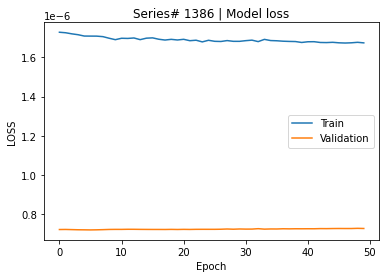

Fit for series: ['FOODS_3_330' 'FOODS_3' 'FOODS' 'CA_3' 'CA']
Fit for series: ['FOODS_3_110' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOBBIES_2_007' 'HOBBIES_2' 'HOBBIES' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_388' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']


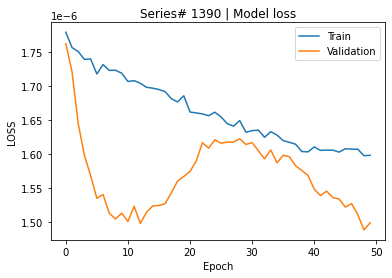

Fit for series: ['FOODS_3_761' 'FOODS_3' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_353' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_2' 'WI']


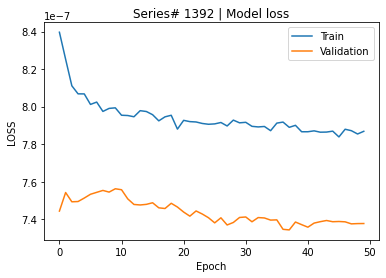

Fit for series: ['HOUSEHOLD_1_440' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOBBIES_1_068' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']


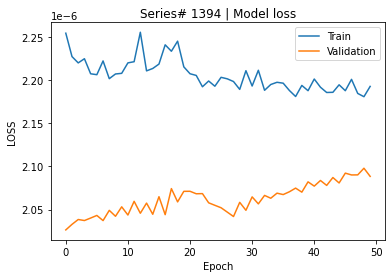

Fit for series: ['FOODS_1_111' 'FOODS_1' 'FOODS' 'WI_1' 'WI']
Fit for series: ['FOODS_3_666' 'FOODS_3' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOBBIES_2_005' 'HOBBIES_2' 'HOBBIES' 'CA_4' 'CA']
Fit for series: ['FOODS_2_011' 'FOODS_2' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_2_186' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']


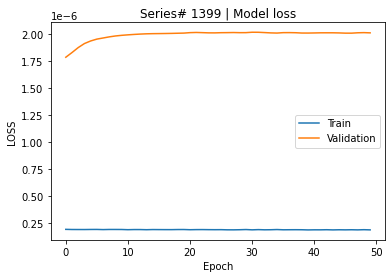

Fit for series: ['FOODS_3_041' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_3_003' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['FOODS_1_142' 'FOODS_1' 'FOODS' 'WI_1' 'WI']
Fit for series: ['HOBBIES_1_250' 'HOBBIES_1' 'HOBBIES' 'TX_1' 'TX']
Fit for series: ['FOODS_3_562' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOBBIES_1_362' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['FOODS_1_045' 'FOODS_1' 'FOODS' 'CA_1' 'CA']


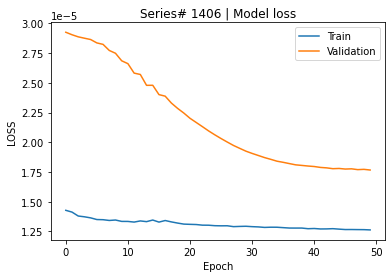

Fit for series: ['HOUSEHOLD_1_321' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOBBIES_1_259' 'HOBBIES_1' 'HOBBIES' 'CA_4' 'CA']
Fit for series: ['HOBBIES_1_227' 'HOBBIES_1' 'HOBBIES' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_506' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_1_200' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']


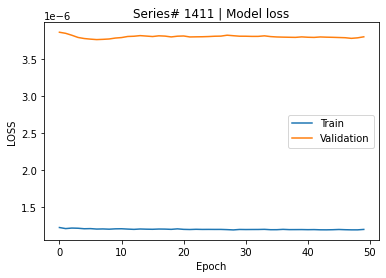

Fit for series: ['HOUSEHOLD_1_407' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_400' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_1_073' 'FOODS_1' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_1_084' 'FOODS_1' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_2_444' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['FOODS_3_532' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_3_005' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_278' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['FOODS_3_369' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_1_522' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_393' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']


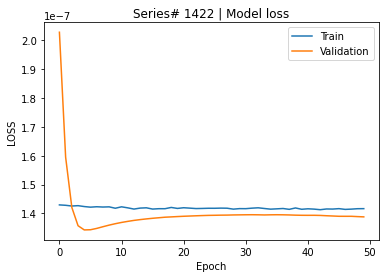

Fit for series: ['HOUSEHOLD_2_282' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_1_349' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_3_323' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_3_100' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOBBIES_2_131' 'HOBBIES_2' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['HOBBIES_2_014' 'HOBBIES_2' 'HOBBIES' 'WI_3' 'WI']
Fit for series: ['FOODS_2_394' 'FOODS_2' 'FOODS' 'CA_3' 'CA']
Fit for series: ['HOBBIES_1_408' 'HOBBIES_1' 'HOBBIES' 'CA_1' 'CA']
Fit for series: ['FOODS_2_310' 'FOODS_2' 'FOODS' 'WI_2' 'WI']


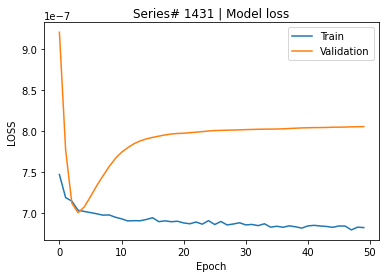

Fit for series: ['HOUSEHOLD_2_015' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']


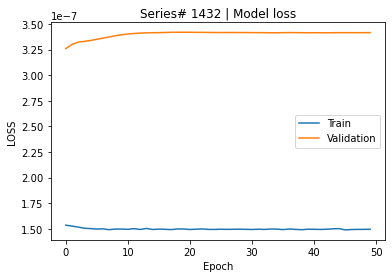

Fit for series: ['FOODS_3_732' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['FOODS_3_439' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_1_258' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_2_361' 'FOODS_2' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_1_369' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_274' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['FOODS_2_011' 'FOODS_2' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOBBIES_1_109' 'HOBBIES_1' 'HOBBIES' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_2_069' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['FOODS_3_594' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_186' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['FOODS_3_246' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOBBIES_1_054' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']


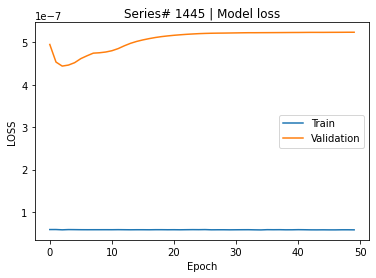

Fit for series: ['HOUSEHOLD_2_267' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['FOODS_2_055' 'FOODS_2' 'FOODS' 'CA_1' 'CA']
Fit for series: ['FOODS_3_418' 'FOODS_3' 'FOODS' 'CA_1' 'CA']


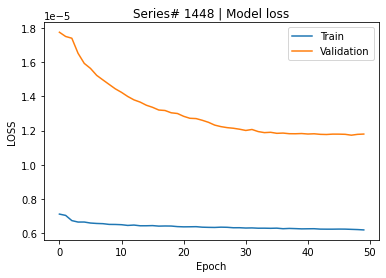

Fit for series: ['FOODS_2_177' 'FOODS_2' 'FOODS' 'TX_1' 'TX']


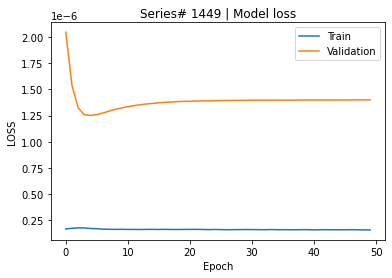

Fit for series: ['HOUSEHOLD_2_435' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_112' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['FOODS_2_190' 'FOODS_2' 'FOODS' 'WI_3' 'WI']


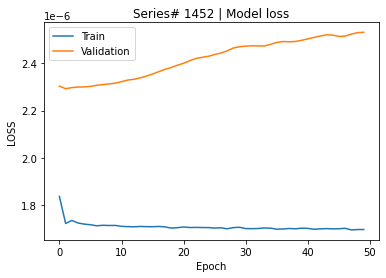

Fit for series: ['HOUSEHOLD_1_289' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOBBIES_2_070' 'HOBBIES_2' 'HOBBIES' 'TX_3' 'TX']
Fit for series: ['FOODS_2_059' 'FOODS_2' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_3_183' 'FOODS_3' 'FOODS' 'CA_1' 'CA']


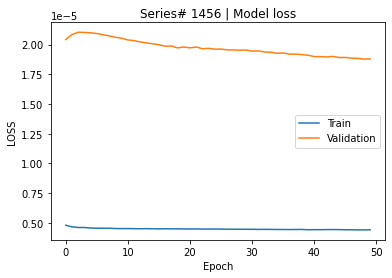

Fit for series: ['HOUSEHOLD_2_239' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOBBIES_1_021' 'HOBBIES_1' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_169' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_1_324' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['FOODS_2_148' 'FOODS_2' 'FOODS' 'WI_3' 'WI']
Fit for series: ['FOODS_1_197' 'FOODS_1' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_1_070' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_1_452' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['FOODS_3_192' 'FOODS_3' 'FOODS' 'TX_3' 'TX']
Fit for series: ['FOODS_2_283' 'FOODS_2' 'FOODS' 'CA_1' 'CA']
Fit for series: ['HOUSEHOLD_1_016' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['FOODS_1_138' 'FOODS_1' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_2_383' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']


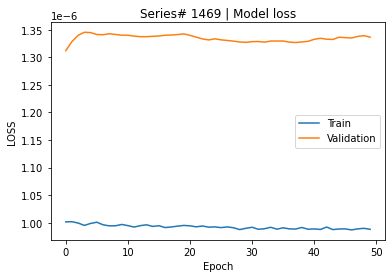

Fit for series: ['HOUSEHOLD_2_110' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_3' 'WI']
Fit for series: ['FOODS_3_442' 'FOODS_3' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOBBIES_2_066' 'HOBBIES_2' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['FOODS_3_250' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['FOODS_1_214' 'FOODS_1' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOBBIES_1_382' 'HOBBIES_1' 'HOBBIES' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_2_028' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_057' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['HOBBIES_1_112' 'HOBBIES_1' 'HOBBIES' 'TX_2' 'TX']
Fit for series: ['FOODS_2_393' 'FOODS_2' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOUSEHOLD_2_400' 'HOUSEHOLD_2' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOBBIES_1_167' 'HOBBIES_1' 'HOBBIES' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_2_398' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['FOODS_3_056' 'FOODS_3' 'FOODS' 'WI_3' 'WI']
Fit for series: ['HOUSEHOLD_1_295' 'HOUSEHOLD_1'

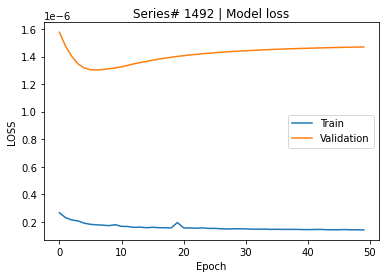

Fit for series: ['HOUSEHOLD_1_022' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['FOODS_3_378' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['FOODS_2_382' 'FOODS_2' 'FOODS' 'TX_2' 'TX']
Fit for series: ['FOODS_2_250' 'FOODS_2' 'FOODS' 'CA_2' 'CA']


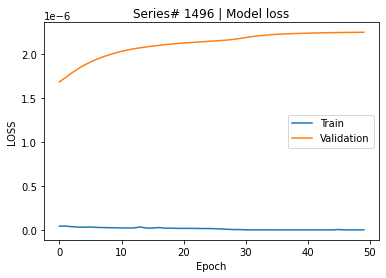

Fit for series: ['FOODS_2_207' 'FOODS_2' 'FOODS' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_1_278' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['FOODS_2_056' 'FOODS_2' 'FOODS' 'TX_2' 'TX']
Fit for series: ['HOBBIES_2_127' 'HOBBIES_2' 'HOBBIES' 'TX_1' 'TX']
Fit for series: ['FOODS_3_581' 'FOODS_3' 'FOODS' 'WI_3' 'WI']


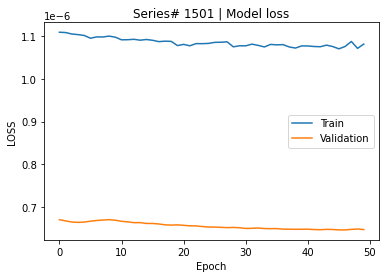

Fit for series: ['FOODS_3_092' 'FOODS_3' 'FOODS' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_2_476' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']
Fit for series: ['FOODS_2_067' 'FOODS_2' 'FOODS' 'CA_4' 'CA']
Fit for series: ['HOUSEHOLD_2_415' 'HOUSEHOLD_2' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['FOODS_2_261' 'FOODS_2' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_275' 'HOUSEHOLD_1' 'HOUSEHOLD' 'CA_2' 'CA']
Fit for series: ['HOUSEHOLD_2_167' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_1' 'CA']
Fit for series: ['FOODS_3_642' 'FOODS_3' 'FOODS' 'WI_1' 'WI']
Fit for series: ['FOODS_1_157' 'FOODS_1' 'FOODS' 'TX_3' 'TX']
Fit for series: ['FOODS_3_109' 'FOODS_3' 'FOODS' 'CA_4' 'CA']
Fit for series: ['FOODS_3_528' 'FOODS_3' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_1_400' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']


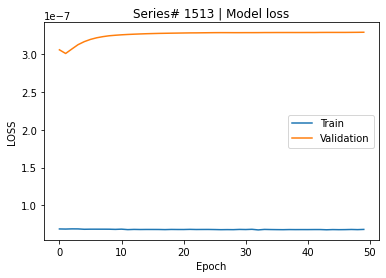

Fit for series: ['FOODS_2_196' 'FOODS_2' 'FOODS' 'TX_1' 'TX']
Fit for series: ['HOUSEHOLD_1_218' 'HOUSEHOLD_1' 'HOUSEHOLD' 'WI_1' 'WI']
Fit for series: ['HOUSEHOLD_1_498' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_1' 'TX']
Fit for series: ['HOBBIES_1_122' 'HOBBIES_1' 'HOBBIES' 'CA_3' 'CA']
Fit for series: ['FOODS_2_140' 'FOODS_2' 'FOODS' 'WI_1' 'WI']
Fit for series: ['FOODS_2_370' 'FOODS_2' 'FOODS' 'WI_2' 'WI']
Fit for series: ['FOODS_1_148' 'FOODS_1' 'FOODS' 'WI_2' 'WI']
Fit for series: ['HOUSEHOLD_1_305' 'HOUSEHOLD_1' 'HOUSEHOLD' 'TX_3' 'TX']
Fit for series: ['HOUSEHOLD_2_281' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_3' 'CA']
Fit for series: ['HOUSEHOLD_2_349' 'HOUSEHOLD_2' 'HOUSEHOLD' 'CA_4' 'CA']


In [27]:
for series_index in range(NUM_SERIES):
    print("Fit for series:", series_index,
          sales_train_validation.loc[sales_train_validation.index == series_index][CARDINALS].values[0])
    fit_history = model.fit(
        x = {
                'cat_input' : repeater(categoricals[[series_index], CARDINALS.index("cat_id")]),
                'dept_input' : repeater(categoricals[[series_index], CARDINALS.index("dept_id")]),
                'item_input' : repeater(categoricals[[series_index], CARDINALS.index("item_id")]),
                'state_input' : repeater(categoricals[[series_index], CARDINALS.index("state_id")]),
                'store_input' : repeater(categoricals[[series_index], CARDINALS.index("store_id")]),
                'time_series_input' : X[:,:,[series_index]],
        },
        y = {'time_series_output' : Y[:,:,[series_index]]},
        batch_size = BS,
        epochs = NUM_EPOCHS,
        verbose = 0,
        callbacks = [mcp, csvl],
        validation_split = TRAILING_VAL_RATIO,
        shuffle = False
    )

    if PLOTTING==True and np.random.random()>0.9:
        for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
            plt.plot(fit_history.history[i])
            plt.plot(fit_history.history[j])
            plt.title('Series# ' + str(series_index) + ' | Model ' + i)
            plt.ylabel(i.upper())
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'])
            plt.show()

In [28]:
end_time = ctime(time())
print(end_time)

Sun Jun  7 11:28:33 2020


#### Validation Metrics

valid_idx = np.int(np.round(len(X)*0.2))
model.evaluate(X[-valid_idx:], Y[-valid_idx:])

pred = model.predict(X[-1:,:,:], batch_size=BS)
pred = pred.reshape((NUM_TIMESTEPS, NUM_SERIES))
pred = MMS.inverse_transform(pred).astype(int)

mean_squared_error(y_true=Y[-1], y_pred=pred)

## Scaling is shit... Do it for the whole 2D array instead

## Add weights during training... inside the fit call you need dynamic weighting

## Add More Features

## Add Conv1D